In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground02"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if "foreground" in test:
    members= pd.read_pickle('/home/cz136/project/sa/data/{}/{}/{}.pkl'.format(shape_cat,vol,test))
elif "background" in test:
    members= pd.read_pickle('/home/cz136/project/sa/data/{}/{}/{}.pkl'.format(shape_cat,vol,test))
elif test=="":
    pass
else:
    raise TypeError

In [5]:
if vol!="uber":
    members=shapes

In [6]:
if quantile!="":
    i=int(quantile)

In [7]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [8]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [9]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [10]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [11]:
NBINS=10

In [12]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [13]:
len(shapes)

1079244

In [14]:
len(members)

61519

In [15]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [16]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [17]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [18]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [19]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:01,  1.99s/it]

12it [00:02,  1.39s/it]

23it [00:02,  1.02it/s]

33it [00:02,  1.45it/s]

40it [00:02,  2.06it/s]

47it [00:02,  2.89it/s]

54it [00:02,  4.06it/s]

62it [00:02,  5.66it/s]

72it [00:02,  7.88it/s]

80it [00:02, 10.78it/s]

88it [00:03, 14.50it/s]

96it [00:03, 18.90it/s]

104it [00:03, 23.70it/s]

112it [00:03, 29.88it/s]

121it [00:03, 37.11it/s]

129it [00:03, 44.06it/s]

140it [00:03, 52.83it/s]

149it [00:03, 57.10it/s]

157it [00:03, 61.17it/s]

166it [00:04, 66.71it/s]

175it [00:04, 71.04it/s]

184it [00:04, 70.32it/s]

192it [00:04, 72.06it/s]

202it [00:04, 78.04it/s]

211it [00:04, 80.02it/s]

220it [00:04, 73.21it/s]

228it [00:04, 71.42it/s]

236it [00:05, 71.97it/s]

245it [00:05, 75.28it/s]

253it [00:05, 73.28it/s]

262it [00:05, 75.43it/s]

270it [00:05, 73.78it/s]

278it [00:05, 74.81it/s]

286it [00:05, 75.36it/s]

295it [00:05, 78.05it/s]

304it [00:05, 79.04it/s]

312it [00:06, 79.03it/s]

320it [00:06, 76.23it/s]

328it [00:06, 74.45it/s]

337it [00:06, 74.91it/s]

345it [00:06, 72.58it/s]

354it [00:06, 73.94it/s]

362it [00:06, 72.93it/s]

372it [00:06, 78.96it/s]

381it [00:06, 76.21it/s]

390it [00:07, 79.67it/s]

399it [00:07, 73.40it/s]

408it [00:07, 74.65it/s]

416it [00:07, 71.08it/s]

426it [00:07, 76.70it/s]

435it [00:07, 78.69it/s]

444it [00:07, 81.21it/s]

453it [00:07, 79.39it/s]

462it [00:07, 80.68it/s]

471it [00:08, 79.06it/s]

479it [00:08, 68.67it/s]

487it [00:08, 69.94it/s]

496it [00:08, 73.58it/s]

504it [00:08, 74.09it/s]

512it [00:08, 71.59it/s]

520it [00:08, 72.21it/s]

528it [00:08, 69.38it/s]

537it [00:09, 73.29it/s]

545it [00:09, 70.71it/s]

553it [00:09, 71.09it/s]

561it [00:09, 71.39it/s]

569it [00:09, 73.18it/s]

577it [00:09, 70.88it/s]

587it [00:09, 76.75it/s]

596it [00:09, 79.90it/s]

605it [00:09, 79.20it/s]

614it [00:10, 79.13it/s]

623it [00:10, 81.51it/s]

632it [00:10, 80.94it/s]

641it [00:10, 78.14it/s]

649it [00:10, 77.33it/s]

658it [00:10, 76.89it/s]

666it [00:10, 77.31it/s]

674it [00:10, 77.21it/s]

682it [00:10, 73.70it/s]

691it [00:11, 76.32it/s]

700it [00:11, 78.55it/s]

710it [00:11, 82.68it/s]

719it [00:11, 81.77it/s]

728it [00:11, 81.47it/s]

737it [00:11, 83.24it/s]

746it [00:11, 79.41it/s]

755it [00:11, 72.11it/s]

763it [00:11, 70.83it/s]

771it [00:12, 72.80it/s]

779it [00:12, 68.01it/s]

786it [00:12, 64.08it/s]

793it [00:12, 64.93it/s]

803it [00:12, 71.32it/s]

811it [00:12, 70.57it/s]

819it [00:12, 70.05it/s]

827it [00:12, 71.46it/s]

835it [00:13, 66.00it/s]

844it [00:13, 69.46it/s]

852it [00:13, 69.94it/s]

862it [00:13, 73.94it/s]

872it [00:13, 77.67it/s]

882it [00:13, 83.20it/s]

891it [00:13, 79.38it/s]

900it [00:13, 77.21it/s]

909it [00:13, 79.19it/s]

918it [00:14, 77.88it/s]

926it [00:14, 74.12it/s]

934it [00:14, 71.62it/s]

944it [00:14, 77.86it/s]

953it [00:14, 74.57it/s]

962it [00:14, 78.30it/s]

971it [00:14, 77.83it/s]

979it [00:14, 77.30it/s]

988it [00:14, 80.14it/s]

997it [00:15, 79.86it/s]

1006it [00:15, 79.22it/s]

1017it [00:15, 83.37it/s]

1026it [00:15, 85.26it/s]

1037it [00:15, 90.05it/s]

1047it [00:15, 83.77it/s]

1056it [00:15, 82.06it/s]

1065it [00:15, 79.88it/s]

1074it [00:15, 80.89it/s]

1083it [00:16, 79.85it/s]

1092it [00:16, 72.50it/s]

1100it [00:16, 72.59it/s]

1108it [00:16, 69.25it/s]

1117it [00:16, 71.23it/s]

1126it [00:16, 74.36it/s]

1136it [00:16, 77.99it/s]

1145it [00:16, 77.92it/s]

1153it [00:17, 69.54it/s]

1162it [00:17, 72.50it/s]

1170it [00:17, 69.29it/s]

1178it [00:17, 68.34it/s]

1188it [00:17, 72.64it/s]

1197it [00:17, 74.61it/s]

1205it [00:17, 71.70it/s]

1213it [00:17, 73.23it/s]

1221it [00:17, 74.36it/s]

1230it [00:18, 77.42it/s]

1239it [00:18, 77.68it/s]

1247it [00:18, 75.84it/s]

1258it [00:18, 80.31it/s]

1267it [00:18, 77.34it/s]

1277it [00:18, 82.03it/s]

1286it [00:18, 81.95it/s]

1295it [00:18, 76.83it/s]

1304it [00:19, 79.56it/s]

1313it [00:19, 78.21it/s]

1321it [00:19, 72.84it/s]

1329it [00:19, 72.84it/s]

1337it [00:19, 68.24it/s]

1344it [00:19, 63.66it/s]

1353it [00:19, 68.01it/s]

1362it [00:19, 72.96it/s]

1370it [00:19, 70.66it/s]

1378it [00:20, 68.11it/s]

1386it [00:20, 69.10it/s]

1395it [00:20, 72.69it/s]

1403it [00:20, 71.62it/s]

1411it [00:20, 67.38it/s]

1418it [00:20, 67.71it/s]

1426it [00:20, 69.68it/s]

1434it [00:20, 68.84it/s]

1442it [00:21, 70.06it/s]

1450it [00:21, 70.92it/s]

1458it [00:21, 71.27it/s]

1466it [00:21, 68.17it/s]

1475it [00:21, 72.60it/s]

1483it [00:21, 72.15it/s]

1491it [00:21, 74.19it/s]

1499it [00:21, 74.35it/s]

1507it [00:21, 70.32it/s]

1515it [00:22, 70.51it/s]

1524it [00:22, 74.11it/s]

1532it [00:22, 73.99it/s]

1540it [00:22, 66.72it/s]

1547it [00:22, 60.78it/s]

1555it [00:22, 64.03it/s]

1565it [00:22, 70.10it/s]

1574it [00:22, 74.25it/s]

1582it [00:22, 72.50it/s]

1591it [00:23, 75.78it/s]

1599it [00:23, 74.43it/s]

1608it [00:23, 77.85it/s]

1619it [00:23, 82.71it/s]

1628it [00:23, 76.84it/s]

1636it [00:23, 75.81it/s]

1646it [00:23, 80.83it/s]

1655it [00:23, 81.72it/s]

1664it [00:23, 78.10it/s]

1672it [00:24, 77.97it/s]

1683it [00:24, 83.98it/s]

1692it [00:24, 78.00it/s]

1701it [00:24, 78.95it/s]

1710it [00:24, 74.02it/s]

1719it [00:24, 78.05it/s]

1728it [00:24, 80.75it/s]

1738it [00:24, 84.88it/s]

1747it [00:25, 79.17it/s]

1756it [00:25, 78.06it/s]

1764it [00:25, 77.09it/s]

1773it [00:25, 80.12it/s]

1782it [00:25, 76.76it/s]

1790it [00:25, 68.92it/s]

1798it [00:25, 69.19it/s]

1808it [00:25, 74.70it/s]

1816it [00:25, 75.35it/s]

1824it [00:26, 70.16it/s]

1832it [00:26, 68.95it/s]

1840it [00:26, 66.74it/s]

1848it [00:26, 69.05it/s]

1856it [00:26, 67.46it/s]

1865it [00:26, 70.89it/s]

1873it [00:26, 72.84it/s]

1882it [00:26, 75.79it/s]

1890it [00:27, 72.87it/s]

1900it [00:27, 78.32it/s]

1909it [00:27, 75.10it/s]

1917it [00:27, 74.04it/s]

1925it [00:27, 71.90it/s]

1933it [00:27, 63.51it/s]

1944it [00:27, 71.65it/s]

1952it [00:27, 73.23it/s]

1960it [00:27, 73.98it/s]

1968it [00:28, 68.08it/s]

1978it [00:28, 74.14it/s]

1986it [00:28, 72.73it/s]

1994it [00:28, 74.04it/s]

2002it [00:28, 69.82it/s]

2010it [00:28, 71.70it/s]

2018it [00:28, 68.18it/s]

2025it [00:28, 65.85it/s]

2033it [00:29, 68.72it/s]

2042it [00:29, 73.91it/s]

2053it [00:29, 79.05it/s]

2062it [00:29, 78.88it/s]

2072it [00:29, 83.74it/s]

2081it [00:29, 80.35it/s]

2090it [00:29, 77.76it/s]

2098it [00:29, 75.93it/s]

2107it [00:29, 79.09it/s]

2116it [00:30, 75.34it/s]

2124it [00:30, 74.55it/s]

2132it [00:30, 74.49it/s]

2140it [00:30, 74.89it/s]

2148it [00:30, 75.67it/s]

2156it [00:30, 72.35it/s]

2166it [00:30, 78.44it/s]

2175it [00:30, 81.23it/s]

2184it [00:30, 78.32it/s]

2192it [00:31, 77.04it/s]

2202it [00:31, 80.11it/s]

2211it [00:31, 81.45it/s]

2220it [00:31, 75.75it/s]

2228it [00:31, 74.00it/s]

2236it [00:31, 71.38it/s]

2244it [00:31, 70.23it/s]

2253it [00:31, 73.53it/s]

2262it [00:31, 77.63it/s]

2270it [00:32, 76.16it/s]

2278it [00:32, 75.43it/s]

2286it [00:32, 71.78it/s]

2294it [00:32, 72.45it/s]

2303it [00:32, 76.14it/s]

2311it [00:32, 71.66it/s]

2319it [00:32, 70.10it/s]

2328it [00:32, 72.11it/s]

2337it [00:32, 73.71it/s]

2345it [00:33, 74.05it/s]

2354it [00:33, 74.82it/s]

2362it [00:33, 72.61it/s]

2370it [00:33, 70.48it/s]

2378it [00:33, 67.60it/s]

2387it [00:33, 71.56it/s]

2395it [00:33, 69.66it/s]

2403it [00:33, 71.22it/s]

2412it [00:34, 75.05it/s]

2422it [00:34, 79.59it/s]

2431it [00:34, 77.33it/s]

2439it [00:34, 73.98it/s]

2447it [00:34, 74.43it/s]

2457it [00:34, 79.72it/s]

2466it [00:34, 77.53it/s]

2474it [00:34, 69.15it/s]

2484it [00:34, 74.84it/s]

2492it [00:35, 71.15it/s]

2500it [00:35, 68.53it/s]

2508it [00:35, 66.64it/s]

2515it [00:35, 65.14it/s]

2522it [00:35, 65.39it/s]

2530it [00:35, 66.42it/s]

2537it [00:35, 65.58it/s]

2544it [00:35, 60.54it/s]

2551it [00:36, 62.63it/s]

2558it [00:36, 63.62it/s]

2567it [00:36, 67.42it/s]

2575it [00:36, 69.70it/s]

2583it [00:36, 70.20it/s]

2592it [00:36, 74.20it/s]

2601it [00:36, 77.85it/s]

2610it [00:36, 80.11it/s]

2619it [00:36, 77.75it/s]

2628it [00:36, 79.72it/s]

2637it [00:37, 75.01it/s]

2645it [00:37, 75.65it/s]

2653it [00:37, 72.89it/s]

2661it [00:37, 68.04it/s]

2668it [00:37, 65.50it/s]

2676it [00:37, 68.35it/s]

2683it [00:37, 63.92it/s]

2691it [00:37, 66.02it/s]

2699it [00:38, 69.63it/s]

2708it [00:38, 73.69it/s]

2718it [00:38, 78.55it/s]

2728it [00:38, 83.56it/s]

2737it [00:38, 79.28it/s]

2746it [00:38, 78.88it/s]

2755it [00:38, 70.35it/s]

2763it [00:38, 69.45it/s]

2771it [00:38, 72.23it/s]

2779it [00:39, 69.44it/s]

2789it [00:39, 74.18it/s]

2797it [00:39, 75.62it/s]

2805it [00:39, 73.92it/s]

2814it [00:39, 75.02it/s]

2823it [00:39, 78.34it/s]

2831it [00:39, 78.65it/s]

2839it [00:39, 75.53it/s]

2848it [00:39, 76.54it/s]

2856it [00:40, 70.35it/s]

2864it [00:40, 67.22it/s]

2873it [00:40, 71.53it/s]

2882it [00:40, 74.49it/s]

2892it [00:40, 79.16it/s]

2901it [00:40, 76.34it/s]

2910it [00:40, 77.02it/s]

2918it [00:40, 76.00it/s]

2926it [00:41, 71.18it/s]

2934it [00:41, 72.78it/s]

2942it [00:41, 71.59it/s]

2950it [00:41, 67.89it/s]

2958it [00:41, 68.35it/s]

2967it [00:41, 72.16it/s]

2976it [00:41, 76.59it/s]

2985it [00:41, 79.98it/s]

2994it [00:41, 79.39it/s]

3003it [00:42, 79.17it/s]

3011it [00:42, 77.42it/s]

3019it [00:42, 75.79it/s]

3028it [00:42, 76.26it/s]

3036it [00:42, 76.79it/s]

3045it [00:42, 78.42it/s]

3053it [00:42, 74.24it/s]

3061it [00:42, 75.52it/s]

3070it [00:42, 76.81it/s]

3081it [00:43, 83.89it/s]

3090it [00:43, 78.93it/s]

3099it [00:43, 78.64it/s]

3108it [00:43, 79.28it/s]

3117it [00:43, 77.05it/s]

3125it [00:43, 73.64it/s]

3133it [00:43, 71.68it/s]

3142it [00:43, 75.11it/s]

3150it [00:43, 73.58it/s]

3158it [00:44, 73.71it/s]

3166it [00:44, 70.88it/s]

3174it [00:44, 70.92it/s]

3182it [00:44, 69.40it/s]

3190it [00:44, 71.64it/s]

3199it [00:44, 75.12it/s]

3207it [00:44, 75.43it/s]

3215it [00:44, 74.89it/s]

3223it [00:44, 74.66it/s]

3232it [00:45, 77.62it/s]

3241it [00:45, 80.43it/s]

3250it [00:45, 78.56it/s]

3258it [00:45, 77.36it/s]

3268it [00:45, 82.29it/s]

3277it [00:45, 81.50it/s]

3286it [00:45, 74.13it/s]

3294it [00:45, 71.77it/s]

3303it [00:46, 73.85it/s]

3311it [00:46, 73.74it/s]

3321it [00:46, 78.86it/s]

3330it [00:46, 79.22it/s]

3339it [00:46, 80.79it/s]

3348it [00:46, 81.83it/s]

3357it [00:46, 76.34it/s]

3366it [00:46, 79.25it/s]

3375it [00:46, 76.79it/s]

3383it [00:47, 77.63it/s]

3392it [00:47, 77.70it/s]

3400it [00:47, 73.72it/s]

3408it [00:47, 72.05it/s]

3417it [00:47, 75.51it/s]

3426it [00:47, 78.69it/s]

3435it [00:47, 81.08it/s]

3444it [00:47, 71.85it/s]

3452it [00:47, 72.36it/s]

3462it [00:48, 77.84it/s]

3471it [00:48, 78.59it/s]

3482it [00:48, 83.64it/s]

3491it [00:48, 79.66it/s]

3500it [00:48, 80.17it/s]

3509it [00:48, 78.36it/s]

3518it [00:48, 79.33it/s]

3527it [00:48, 82.19it/s]

3536it [00:48, 82.15it/s]

3546it [00:49, 85.68it/s]

3555it [00:49, 83.55it/s]

3564it [00:49, 80.38it/s]

3573it [00:49, 76.07it/s]

3581it [00:49, 76.82it/s]

3592it [00:49, 81.03it/s]

3601it [00:49, 80.34it/s]

3610it [00:49, 76.75it/s]

3618it [00:50, 73.94it/s]

3626it [00:50, 70.91it/s]

3634it [00:50, 70.85it/s]

3642it [00:50, 67.31it/s]

3650it [00:50, 69.18it/s]

3659it [00:50, 73.39it/s]

3667it [00:50, 74.67it/s]

3675it [00:50, 70.60it/s]

3683it [00:50, 71.35it/s]

3692it [00:51, 73.28it/s]

3700it [00:51, 67.34it/s]

3708it [00:51, 68.36it/s]

3715it [00:51, 66.53it/s]

3724it [00:51, 70.56it/s]

3732it [00:51, 68.90it/s]

3740it [00:51, 70.33it/s]

3748it [00:51, 70.42it/s]

3758it [00:51, 77.20it/s]

3768it [00:52, 79.39it/s]

3777it [00:52, 78.07it/s]

3786it [00:52, 79.85it/s]

3795it [00:52, 72.53it/s]

3803it [00:52, 73.41it/s]

3811it [00:52, 69.23it/s]

3819it [00:52, 71.96it/s]

3829it [00:52, 78.31it/s]

3838it [00:53, 80.92it/s]

3847it [00:53, 82.34it/s]

3856it [00:53, 79.29it/s]

3866it [00:53, 84.00it/s]

3875it [00:53, 77.39it/s]

3883it [00:53, 73.48it/s]

3894it [00:53, 80.08it/s]

3904it [00:53, 82.69it/s]

3913it [00:53, 76.50it/s]

3923it [00:54, 81.36it/s]

3932it [00:54, 76.44it/s]

3940it [00:54, 71.42it/s]

3949it [00:54, 74.56it/s]

3957it [00:54, 67.87it/s]

3965it [00:54, 66.38it/s]

3972it [00:54, 62.05it/s]

3979it [00:54, 61.42it/s]

3986it [00:55, 57.82it/s]

3994it [00:55, 62.27it/s]

4001it [00:55, 64.24it/s]

4009it [00:55, 67.93it/s]

4019it [00:55, 73.09it/s]

4027it [00:55, 71.82it/s]

4035it [00:55, 69.45it/s]

4043it [00:55, 72.30it/s]

4051it [00:55, 68.35it/s]

4059it [00:56, 68.30it/s]

4066it [00:56, 67.67it/s]

4074it [00:56, 69.61it/s]

4082it [00:56, 71.24it/s]

4092it [00:56, 77.90it/s]

4101it [00:56, 79.63it/s]

4110it [00:56, 77.54it/s]

4118it [00:56, 72.18it/s]

4126it [00:57, 68.50it/s]

4136it [00:57, 75.62it/s]

4144it [00:57, 68.71it/s]

4152it [00:57, 65.14it/s]

4159it [00:57, 64.48it/s]

4169it [00:57, 70.41it/s]

4177it [00:57, 72.90it/s]

4185it [00:57, 70.75it/s]

4193it [00:57, 69.09it/s]

4201it [00:58, 69.89it/s]

4211it [00:58, 75.26it/s]

4219it [00:58, 72.43it/s]

4228it [00:58, 75.82it/s]

4236it [00:58, 72.27it/s]

4244it [00:58, 72.60it/s]

4252it [00:58, 70.21it/s]

4260it [00:58, 69.47it/s]

4269it [00:58, 74.03it/s]

4279it [00:59, 76.49it/s]

4287it [00:59, 75.38it/s]

4295it [00:59, 71.42it/s]

4303it [00:59, 71.67it/s]

4312it [00:59, 73.99it/s]

4320it [00:59, 72.86it/s]

4328it [00:59, 69.80it/s]

4337it [00:59, 73.68it/s]

4345it [01:00, 70.90it/s]

4353it [01:00, 67.96it/s]

4360it [01:00, 67.37it/s]

4369it [01:00, 70.61it/s]

4378it [01:00, 74.31it/s]

4387it [01:00, 76.74it/s]

4396it [01:00, 79.18it/s]

4405it [01:00, 70.16it/s]

4413it [01:00, 70.54it/s]

4422it [01:01, 74.28it/s]

4430it [01:01, 71.28it/s]

4438it [01:01, 72.85it/s]

4446it [01:01, 72.59it/s]

4454it [01:01, 73.33it/s]

4463it [01:01, 74.29it/s]

4471it [01:01, 69.07it/s]

4481it [01:01, 75.52it/s]

4489it [01:01, 71.79it/s]

4498it [01:02, 74.29it/s]

4506it [01:02, 71.66it/s]

4516it [01:02, 77.99it/s]

4525it [01:02, 77.80it/s]

4533it [01:02, 73.22it/s]

4541it [01:02, 71.02it/s]

4549it [01:02, 67.63it/s]

4558it [01:02, 72.45it/s]

4566it [01:03, 68.22it/s]

4576it [01:03, 75.39it/s]

4584it [01:03, 74.92it/s]

4593it [01:03, 78.23it/s]

4602it [01:03, 71.78it/s]

4610it [01:03, 67.96it/s]

4618it [01:03, 70.31it/s]

4626it [01:03, 71.75it/s]

4634it [01:03, 73.69it/s]

4642it [01:04, 74.66it/s]

4650it [01:04, 74.71it/s]

4658it [01:04, 71.98it/s]

4666it [01:04, 74.13it/s]

4674it [01:04, 70.72it/s]

4683it [01:04, 74.19it/s]

4691it [01:04, 75.82it/s]

4699it [01:04, 73.44it/s]

4707it [01:04, 69.99it/s]

4715it [01:05, 65.18it/s]

4722it [01:05, 65.55it/s]

4730it [01:05, 65.96it/s]

4737it [01:05, 62.00it/s]

4744it [01:05, 59.54it/s]

4751it [01:05, 58.96it/s]

4758it [01:05, 61.38it/s]

4765it [01:05, 62.36it/s]

4772it [01:06, 61.63it/s]

4779it [01:06, 58.01it/s]

4785it [01:06, 56.87it/s]

4791it [01:06, 51.72it/s]

4799it [01:06, 55.70it/s]

4807it [01:06, 61.20it/s]

4814it [01:06, 60.89it/s]

4821it [01:06, 62.39it/s]

4829it [01:06, 64.46it/s]

4837it [01:07, 67.80it/s]

4846it [01:07, 71.10it/s]

4854it [01:07, 67.47it/s]

4861it [01:07, 65.07it/s]

4869it [01:07, 68.07it/s]

4876it [01:07, 68.04it/s]

4883it [01:07, 68.59it/s]

4890it [01:07, 65.66it/s]

4898it [01:07, 67.74it/s]

4907it [01:08, 71.63it/s]

4916it [01:08, 75.29it/s]

4924it [01:08, 68.52it/s]

4932it [01:08, 61.48it/s]

4939it [01:08, 57.22it/s]

4945it [01:08, 57.90it/s]

4952it [01:08, 60.57it/s]

4959it [01:08, 61.21it/s]

4966it [01:09, 62.46it/s]

4973it [01:09, 61.89it/s]

4981it [01:09, 65.09it/s]

4989it [01:09, 67.33it/s]

4997it [01:09, 67.62it/s]

5004it [01:09, 63.98it/s]

5011it [01:09, 59.02it/s]

5018it [01:09, 55.61it/s]

5025it [01:10, 58.25it/s]

5032it [01:10, 60.00it/s]

5040it [01:10, 61.78it/s]

5048it [01:10, 64.85it/s]

5055it [01:10, 63.62it/s]

5062it [01:10, 63.63it/s]

5070it [01:10, 65.15it/s]

5077it [01:10, 64.88it/s]

5085it [01:10, 68.54it/s]

5092it [01:11, 68.43it/s]

5099it [01:11, 65.22it/s]

5106it [01:11, 66.21it/s]

5113it [01:11, 59.42it/s]

5120it [01:11, 59.86it/s]

5128it [01:11, 63.90it/s]

5136it [01:11, 65.06it/s]

5143it [01:11, 65.76it/s]

5152it [01:11, 68.64it/s]

5160it [01:12, 70.63it/s]

5168it [01:12, 73.00it/s]

5176it [01:12, 67.71it/s]

5183it [01:12, 65.52it/s]

5191it [01:12, 66.07it/s]

5198it [01:12, 65.56it/s]

5207it [01:12, 68.36it/s]

5214it [01:12, 59.84it/s]

5221it [01:13, 61.24it/s]

5228it [01:13, 62.24it/s]

5235it [01:13, 59.86it/s]

5243it [01:13, 64.28it/s]

5250it [01:13, 62.71it/s]

5258it [01:13, 65.97it/s]

5265it [01:13, 64.27it/s]

5273it [01:13, 65.75it/s]

5280it [01:13, 65.13it/s]

5288it [01:14, 67.02it/s]

5296it [01:14, 67.86it/s]

5304it [01:14, 67.92it/s]

5311it [01:14, 66.45it/s]

5318it [01:14, 65.18it/s]

5325it [01:14, 66.47it/s]

5332it [01:14, 65.33it/s]

5339it [01:14, 63.11it/s]

5346it [01:14, 63.98it/s]

5354it [01:15, 65.18it/s]

5361it [01:15, 59.33it/s]

5368it [01:15, 59.62it/s]

5377it [01:15, 65.72it/s]

5385it [01:15, 68.56it/s]

5393it [01:15, 70.01it/s]

5401it [01:15, 65.62it/s]

5409it [01:15, 67.73it/s]

5417it [01:15, 70.06it/s]

5425it [01:16, 72.15it/s]

5433it [01:16, 73.31it/s]

5441it [01:16, 73.81it/s]

5450it [01:16, 77.16it/s]

5458it [01:16, 74.75it/s]

5467it [01:16, 77.09it/s]

5475it [01:16, 71.72it/s]

5483it [01:16, 70.77it/s]

5491it [01:16, 70.24it/s]

5499it [01:17, 70.43it/s]

5508it [01:17, 73.97it/s]

5516it [01:17, 75.44it/s]

5524it [01:17, 76.41it/s]

5532it [01:17, 70.47it/s]

5540it [01:17, 72.16it/s]

5548it [01:17, 69.83it/s]

5556it [01:17, 71.78it/s]

5565it [01:17, 73.53it/s]

5573it [01:18, 75.21it/s]

5581it [01:18, 67.64it/s]

5589it [01:18, 70.51it/s]

5597it [01:18, 67.79it/s]

5604it [01:18, 67.20it/s]

5611it [01:18, 62.50it/s]

5619it [01:18, 65.73it/s]

5626it [01:18, 64.29it/s]

5633it [01:19, 65.76it/s]

5641it [01:19, 66.92it/s]

5648it [01:19, 66.52it/s]

5656it [01:19, 68.37it/s]

5663it [01:19, 68.10it/s]

5671it [01:19, 68.81it/s]

5679it [01:19, 71.42it/s]

5687it [01:19, 67.35it/s]

5695it [01:19, 69.00it/s]

5704it [01:20, 71.35it/s]

5712it [01:20, 68.05it/s]

5721it [01:20, 72.53it/s]

5729it [01:20, 70.60it/s]

5737it [01:20, 73.10it/s]

5745it [01:20, 66.69it/s]

5753it [01:20, 68.69it/s]

5761it [01:20, 65.93it/s]

5768it [01:20, 65.44it/s]

5775it [01:21, 63.53it/s]

5784it [01:21, 69.27it/s]

5792it [01:21, 66.50it/s]

5799it [01:21, 63.31it/s]

5806it [01:21, 61.01it/s]

5814it [01:21, 63.01it/s]

5821it [01:21, 62.96it/s]

5828it [01:21, 59.01it/s]

5835it [01:22, 58.92it/s]

5843it [01:22, 61.08it/s]

5850it [01:22, 62.35it/s]

5857it [01:22, 62.68it/s]

5866it [01:22, 66.38it/s]

5875it [01:22, 71.54it/s]

5883it [01:22, 71.42it/s]

5891it [01:22, 72.88it/s]

5899it [01:22, 69.58it/s]

5907it [01:23, 63.52it/s]

5917it [01:23, 71.16it/s]

5925it [01:23, 73.46it/s]

5933it [01:23, 67.30it/s]

5941it [01:23, 67.97it/s]

5950it [01:23, 72.17it/s]

5958it [01:23, 66.01it/s]

5965it [01:23, 66.53it/s]

5972it [01:24, 65.35it/s]

5981it [01:24, 67.98it/s]

5988it [01:24, 64.01it/s]

5995it [01:24, 62.19it/s]

6003it [01:24, 66.19it/s]

6010it [01:24, 65.67it/s]

6019it [01:24, 69.83it/s]

6027it [01:24, 69.04it/s]

6035it [01:24, 69.54it/s]

6043it [01:25, 70.34it/s]

6052it [01:25, 73.66it/s]

6060it [01:25, 66.42it/s]

6070it [01:25, 72.59it/s]

6078it [01:25, 71.73it/s]

6086it [01:25, 72.28it/s]

6095it [01:25, 75.95it/s]

6103it [01:25, 68.34it/s]

6111it [01:26, 69.18it/s]

6119it [01:26, 67.80it/s]

6126it [01:26, 65.82it/s]

6133it [01:26, 64.70it/s]

6140it [01:26, 61.46it/s]

6147it [01:26, 63.49it/s]

6154it [01:26, 63.06it/s]

6161it [01:26, 55.78it/s]

6167it [01:26, 53.22it/s]

6174it [01:27, 56.74it/s]

6181it [01:27, 58.94it/s]

6188it [01:27, 56.53it/s]

6195it [01:27, 58.29it/s]

6202it [01:27, 57.73it/s]

6208it [01:27, 57.30it/s]

6214it [01:27, 57.44it/s]

6221it [01:27, 60.18it/s]

6228it [01:28, 59.20it/s]

6234it [01:28, 59.17it/s]

6240it [01:28, 59.16it/s]

6246it [01:28, 56.49it/s]

6252it [01:28, 56.57it/s]

6259it [01:28, 58.13it/s]

6266it [01:28, 60.79it/s]

6273it [01:28, 55.83it/s]

6280it [01:28, 58.60it/s]

6286it [01:29, 56.31it/s]

6294it [01:29, 60.44it/s]

6301it [01:29, 62.18it/s]

6308it [01:29, 63.69it/s]

6315it [01:29, 61.69it/s]

6322it [01:29, 59.93it/s]

6330it [01:29, 62.02it/s]

6338it [01:29, 66.22it/s]

6345it [01:29, 61.63it/s]

6352it [01:30, 59.34it/s]

6359it [01:30, 58.77it/s]

6365it [01:30, 57.52it/s]

6371it [01:30, 56.50it/s]

6377it [01:30, 55.91it/s]

6384it [01:30, 59.32it/s]

6391it [01:30, 56.89it/s]

6397it [01:30, 57.23it/s]

6406it [01:30, 61.45it/s]

6413it [01:31, 62.19it/s]

6420it [01:31, 59.15it/s]

6427it [01:31, 61.04it/s]

6434it [01:31, 58.48it/s]

6441it [01:31, 59.92it/s]

6448it [01:31, 61.61it/s]

6455it [01:31, 59.04it/s]

6461it [01:31, 55.09it/s]

6467it [01:32, 53.82it/s]

6473it [01:32, 49.90it/s]

6480it [01:32, 53.85it/s]

6486it [01:32, 54.43it/s]

6492it [01:32, 55.47it/s]

6500it [01:32, 59.75it/s]

6507it [01:32, 58.84it/s]

6513it [01:32, 56.39it/s]

6519it [01:32, 57.15it/s]

6526it [01:33, 58.79it/s]

6532it [01:33, 55.81it/s]

6539it [01:33, 58.09it/s]

6545it [01:33, 57.69it/s]

6551it [01:33, 57.63it/s]

6559it [01:33, 61.15it/s]

6567it [01:33, 64.55it/s]

6574it [01:33, 65.01it/s]

6582it [01:33, 68.64it/s]

6589it [01:34, 62.73it/s]

6596it [01:34, 63.17it/s]

6603it [01:34, 62.07it/s]

6610it [01:34, 60.86it/s]

6617it [01:34, 58.87it/s]

6625it [01:34, 63.61it/s]

6632it [01:34, 59.42it/s]

6639it [01:34, 59.95it/s]

6647it [01:35, 62.64it/s]

6654it [01:35, 61.28it/s]

6661it [01:35, 62.17it/s]

6668it [01:35, 61.64it/s]

6675it [01:35, 60.89it/s]

6684it [01:35, 66.26it/s]

6691it [01:35, 67.22it/s]

6699it [01:35, 68.32it/s]

6706it [01:35, 64.56it/s]

6713it [01:36, 65.93it/s]

6720it [01:36, 59.82it/s]

6727it [01:36, 60.62it/s]

6734it [01:36, 58.19it/s]

6741it [01:36, 61.25it/s]

6748it [01:36, 61.04it/s]

6756it [01:36, 65.31it/s]

6764it [01:36, 68.02it/s]

6771it [01:36, 62.88it/s]

6778it [01:37, 60.24it/s]

6785it [01:37, 57.32it/s]

6792it [01:37, 57.76it/s]

6798it [01:37, 57.36it/s]

6804it [01:37, 55.27it/s]

6810it [01:37, 52.28it/s]

6816it [01:37, 49.31it/s]

6822it [01:37, 50.51it/s]

6829it [01:38, 54.71it/s]

6836it [01:38, 57.97it/s]

6844it [01:38, 61.29it/s]

6852it [01:38, 63.36it/s]

6859it [01:38, 62.70it/s]

6866it [01:38, 60.29it/s]

6873it [01:38, 59.85it/s]

6880it [01:38, 61.27it/s]

6887it [01:39, 55.94it/s]

6894it [01:39, 56.46it/s]

6902it [01:39, 60.87it/s]

6909it [01:39, 60.03it/s]

6916it [01:39, 60.92it/s]

6923it [01:39, 57.47it/s]

6929it [01:39, 58.08it/s]

6936it [01:39, 58.95it/s]

6943it [01:39, 61.01it/s]

6950it [01:40, 60.78it/s]

6957it [01:40, 61.18it/s]

6964it [01:40, 62.28it/s]

6971it [01:40, 63.92it/s]

6978it [01:40, 64.38it/s]

6985it [01:40, 62.19it/s]

6992it [01:40, 63.84it/s]

6999it [01:40, 60.22it/s]

7006it [01:40, 58.55it/s]

7014it [01:41, 60.74it/s]

7021it [01:41, 59.75it/s]

7028it [01:41, 60.04it/s]

7035it [01:41, 59.39it/s]

7041it [01:41, 58.67it/s]

7047it [01:41, 57.06it/s]

7053it [01:41, 56.14it/s]

7060it [01:41, 56.92it/s]

7067it [01:41, 59.57it/s]

7074it [01:42, 58.04it/s]

7081it [01:42, 59.42it/s]

7089it [01:42, 61.27it/s]

7097it [01:42, 63.18it/s]

7104it [01:42, 59.71it/s]

7111it [01:42, 61.06it/s]

7118it [01:42, 63.28it/s]

7125it [01:42, 61.18it/s]

7132it [01:43, 58.21it/s]

7138it [01:43, 54.66it/s]

7144it [01:43, 51.28it/s]

7150it [01:43, 51.80it/s]

7156it [01:43, 51.09it/s]

7162it [01:43, 52.58it/s]

7168it [01:43, 52.41it/s]

7174it [01:43, 52.64it/s]

7180it [01:43, 53.12it/s]

7187it [01:44, 56.65it/s]

7194it [01:44, 57.84it/s]

7200it [01:44, 58.41it/s]

7209it [01:44, 63.33it/s]

7216it [01:44, 58.22it/s]

7224it [01:44, 60.62it/s]

7231it [01:44, 57.49it/s]

7237it [01:44, 57.19it/s]

7243it [01:45, 52.82it/s]

7249it [01:45, 51.78it/s]

7255it [01:45, 51.85it/s]

7261it [01:45, 51.93it/s]

7268it [01:45, 55.22it/s]

7274it [01:45, 54.14it/s]

7280it [01:45, 54.75it/s]

7287it [01:45, 57.79it/s]

7294it [01:45, 59.26it/s]

7301it [01:46, 61.28it/s]

7308it [01:46, 62.84it/s]

7315it [01:46, 62.87it/s]

7322it [01:46, 62.52it/s]

7330it [01:46, 65.48it/s]

7337it [01:46, 65.52it/s]

7344it [01:46, 62.08it/s]

7351it [01:46, 62.69it/s]

7358it [01:46, 62.27it/s]

7365it [01:47, 63.57it/s]

7373it [01:47, 66.87it/s]

7380it [01:47, 57.68it/s]

7387it [01:47, 54.63it/s]

7393it [01:47, 52.58it/s]

7400it [01:47, 54.32it/s]

7406it [01:47, 54.78it/s]

7413it [01:47, 55.88it/s]

7420it [01:48, 57.46it/s]

7426it [01:48, 57.59it/s]

7432it [01:48, 55.00it/s]

7439it [01:48, 56.50it/s]

7445it [01:48, 55.58it/s]

7452it [01:48, 57.62it/s]

7459it [01:48, 59.74it/s]

7466it [01:48, 61.32it/s]

7474it [01:48, 63.68it/s]

7481it [01:49, 60.15it/s]

7488it [01:49, 57.87it/s]

7497it [01:49, 64.58it/s]

7504it [01:49, 65.09it/s]

7511it [01:49, 64.51it/s]

7518it [01:49, 59.09it/s]

7525it [01:49, 59.34it/s]

7532it [01:49, 59.20it/s]

7539it [01:50, 58.54it/s]

7545it [01:50, 54.68it/s]

7551it [01:50, 52.74it/s]

7558it [01:50, 55.30it/s]

7565it [01:50, 58.38it/s]

7573it [01:50, 60.61it/s]

7580it [01:50, 60.63it/s]

7588it [01:50, 62.88it/s]

7595it [01:50, 59.71it/s]

7602it [01:51, 55.51it/s]

7608it [01:51, 55.91it/s]

7614it [01:51, 56.31it/s]

7621it [01:51, 56.72it/s]

7627it [01:51, 54.47it/s]

7636it [01:51, 60.37it/s]

7643it [01:51, 59.03it/s]

7650it [01:51, 56.54it/s]

7656it [01:52, 52.47it/s]

7662it [01:52, 53.78it/s]

7668it [01:52, 54.61it/s]

7674it [01:52, 49.45it/s]

7681it [01:52, 51.90it/s]

7687it [01:52, 48.31it/s]

7693it [01:52, 51.06it/s]

7701it [01:52, 56.53it/s]

7708it [01:53, 57.32it/s]

7714it [01:53, 53.84it/s]

7720it [01:53, 51.21it/s]

7726it [01:53, 48.36it/s]

7733it [01:53, 50.84it/s]

7739it [01:53, 52.91it/s]

7745it [01:53, 54.01it/s]

7753it [01:53, 58.85it/s]

7760it [01:53, 61.30it/s]

7767it [01:54, 55.75it/s]

7773it [01:54, 53.04it/s]

7780it [01:54, 56.43it/s]

7787it [01:54, 56.79it/s]

7793it [01:54, 55.56it/s]

7799it [01:54, 53.52it/s]

7805it [01:54, 53.25it/s]

7813it [01:54, 57.16it/s]

7819it [01:55, 57.61it/s]

7826it [01:55, 58.32it/s]

7832it [01:55, 55.07it/s]

7838it [01:55, 55.95it/s]

7845it [01:55, 58.21it/s]

7853it [01:55, 62.25it/s]

7860it [01:55, 62.80it/s]

7867it [01:55, 61.63it/s]

7874it [01:55, 58.51it/s]

7880it [01:56, 58.51it/s]

7887it [01:56, 59.24it/s]

7894it [01:56, 61.38it/s]

7901it [01:56, 63.30it/s]

7908it [01:56, 59.80it/s]

7915it [01:56, 59.78it/s]

7922it [01:56, 57.13it/s]

7928it [01:56, 57.78it/s]

7935it [01:56, 60.06it/s]

7942it [01:57, 59.65it/s]

7949it [01:57, 58.66it/s]

7955it [01:57, 55.90it/s]

7961it [01:57, 53.81it/s]

7967it [01:57, 51.91it/s]

7973it [01:57, 52.72it/s]

7979it [01:57, 52.61it/s]

7986it [01:57, 55.38it/s]

7993it [01:58, 56.47it/s]

7999it [01:58, 57.33it/s]

8005it [01:58, 57.05it/s]

8012it [01:58, 59.67it/s]

8019it [01:58, 60.48it/s]

8028it [01:58, 64.67it/s]

8035it [01:58, 65.93it/s]

8042it [01:58, 64.12it/s]

8049it [01:58, 61.84it/s]

8056it [01:59, 60.02it/s]

8063it [01:59, 58.93it/s]

8069it [01:59, 56.39it/s]

8075it [01:59, 55.87it/s]

8081it [01:59, 56.41it/s]

8087it [01:59, 53.72it/s]

8093it [01:59, 53.77it/s]

8099it [01:59, 55.37it/s]

8105it [01:59, 55.03it/s]

8112it [02:00, 58.34it/s]

8118it [02:00, 58.54it/s]

8125it [02:00, 61.13it/s]

8132it [02:00, 55.18it/s]

8138it [02:00, 55.85it/s]

8146it [02:00, 60.38it/s]

8153it [02:00, 60.56it/s]

8160it [02:00, 55.24it/s]

8167it [02:01, 57.19it/s]

8174it [02:01, 57.60it/s]

8180it [02:01, 54.21it/s]

8186it [02:01, 54.20it/s]

8193it [02:01, 56.84it/s]

8199it [02:01, 56.44it/s]

8205it [02:01, 57.10it/s]

8212it [02:01, 59.97it/s]

8219it [02:01, 59.98it/s]

8226it [02:02, 60.42it/s]

8233it [02:02, 57.24it/s]

8240it [02:02, 60.13it/s]

8247it [02:02, 60.24it/s]

8254it [02:02, 60.17it/s]

8261it [02:02, 53.67it/s]

8267it [02:02, 55.17it/s]

8273it [02:02, 54.82it/s]

8279it [02:02, 55.22it/s]

8286it [02:03, 57.19it/s]

8292it [02:03, 54.09it/s]

8298it [02:03, 54.33it/s]

8305it [02:03, 55.78it/s]

8312it [02:03, 58.31it/s]

8320it [02:03, 60.63it/s]

8327it [02:03, 60.25it/s]

8334it [02:03, 54.34it/s]

8340it [02:04, 53.57it/s]

8346it [02:04, 51.12it/s]

8352it [02:04, 51.45it/s]

8358it [02:04, 52.21it/s]

8365it [02:04, 53.55it/s]

8371it [02:04, 51.05it/s]

8377it [02:04, 50.02it/s]

8383it [02:04, 49.76it/s]

8389it [02:05, 50.35it/s]

8396it [02:05, 54.01it/s]

8402it [02:05, 53.05it/s]

8408it [02:05, 50.71it/s]

8415it [02:05, 55.01it/s]

8421it [02:05, 52.83it/s]

8427it [02:05, 54.30it/s]

8433it [02:05, 55.51it/s]

8439it [02:05, 54.38it/s]

8446it [02:06, 55.99it/s]

8452it [02:06, 56.88it/s]

8459it [02:06, 57.58it/s]

8466it [02:06, 60.64it/s]

8473it [02:06, 62.62it/s]

8480it [02:06, 60.19it/s]

8487it [02:06, 55.50it/s]

8493it [02:06, 56.04it/s]

8500it [02:06, 57.16it/s]

8506it [02:07, 57.22it/s]

8512it [02:07, 54.72it/s]

8518it [02:07, 55.33it/s]

8524it [02:07, 56.12it/s]

8530it [02:07, 56.20it/s]

8536it [02:07, 53.01it/s]

8543it [02:07, 56.74it/s]

8550it [02:07, 57.88it/s]

8556it [02:07, 56.07it/s]

8562it [02:08, 51.66it/s]

8568it [02:08, 51.27it/s]

8574it [02:08, 52.43it/s]

8580it [02:08, 52.90it/s]

8587it [02:08, 55.13it/s]

8593it [02:08, 54.33it/s]

8599it [02:08, 55.13it/s]

8605it [02:08, 52.69it/s]

8611it [02:09, 53.77it/s]

8617it [02:09, 51.20it/s]

8623it [02:09, 50.61it/s]

8629it [02:09, 50.99it/s]

8635it [02:09, 53.32it/s]

8641it [02:09, 53.79it/s]

8647it [02:09, 52.32it/s]

8653it [02:09, 50.21it/s]

8660it [02:09, 52.57it/s]

8667it [02:10, 55.43it/s]

8674it [02:10, 57.99it/s]

8680it [02:10, 53.38it/s]

8686it [02:10, 54.63it/s]

8693it [02:10, 55.46it/s]

8699it [02:10, 55.07it/s]

8705it [02:10, 48.49it/s]

8711it [02:10, 50.53it/s]

8717it [02:11, 48.39it/s]

8723it [02:11, 50.34it/s]

8730it [02:11, 52.95it/s]

8736it [02:11, 54.21it/s]

8742it [02:11, 53.46it/s]

8748it [02:11, 52.21it/s]

8754it [02:11, 52.49it/s]

8761it [02:11, 56.43it/s]

8767it [02:11, 55.62it/s]

8773it [02:12, 54.32it/s]

8779it [02:12, 50.14it/s]

8785it [02:12, 49.75it/s]

8791it [02:12, 47.74it/s]

8797it [02:12, 50.14it/s]

8803it [02:12, 49.85it/s]

8809it [02:12, 51.52it/s]

8815it [02:12, 52.32it/s]

8822it [02:13, 54.47it/s]

8829it [02:13, 55.84it/s]

8835it [02:13, 55.69it/s]

8841it [02:13, 55.06it/s]

8847it [02:13, 56.32it/s]

8853it [02:13, 43.86it/s]

8861it [02:13, 49.56it/s]

8867it [02:13, 52.08it/s]

8873it [02:14, 51.42it/s]

8879it [02:14, 52.59it/s]

8885it [02:14, 49.70it/s]

8892it [02:14, 52.48it/s]

8898it [02:14, 52.79it/s]

8904it [02:14, 54.61it/s]

8911it [02:14, 55.62it/s]

8917it [02:14, 52.96it/s]

8923it [02:14, 51.65it/s]

8929it [02:15, 52.39it/s]

8935it [02:15, 51.49it/s]

8941it [02:15, 52.16it/s]

8948it [02:15, 54.36it/s]

8955it [02:15, 57.39it/s]

8961it [02:15, 55.44it/s]

8967it [02:15, 56.26it/s]

8973it [02:15, 56.16it/s]

8979it [02:15, 57.01it/s]

8985it [02:16, 55.08it/s]

8991it [02:16, 53.43it/s]

8997it [02:16, 50.99it/s]

9003it [02:16, 49.11it/s]

9008it [02:16, 46.17it/s]

9015it [02:16, 49.10it/s]

9021it [02:16, 50.29it/s]

9027it [02:16, 48.15it/s]

9032it [02:17, 47.56it/s]

9039it [02:17, 51.59it/s]

9045it [02:17, 49.55it/s]

9051it [02:17, 50.50it/s]

9057it [02:17, 50.52it/s]

9063it [02:17, 50.16it/s]

9069it [02:17, 47.89it/s]

9075it [02:17, 48.62it/s]

9080it [02:18, 47.33it/s]

9086it [02:18, 48.80it/s]

9091it [02:18, 48.84it/s]

9097it [02:18, 49.98it/s]

9103it [02:18, 50.18it/s]

9110it [02:18, 53.84it/s]

9116it [02:18, 54.04it/s]

9122it [02:18, 53.43it/s]

9128it [02:18, 54.60it/s]

9134it [02:19, 51.02it/s]

9141it [02:19, 55.13it/s]

9147it [02:19, 53.62it/s]

9153it [02:19, 50.92it/s]

9159it [02:19, 49.85it/s]

9165it [02:19, 51.11it/s]

9171it [02:19, 52.76it/s]

9178it [02:19, 55.29it/s]

9184it [02:19, 53.60it/s]

9190it [02:20, 52.76it/s]

9196it [02:20, 52.47it/s]

9202it [02:20, 50.17it/s]

9208it [02:20, 51.42it/s]

9216it [02:20, 55.72it/s]

9222it [02:20, 55.78it/s]

9228it [02:20, 53.45it/s]

9234it [02:20, 53.60it/s]

9240it [02:21, 54.35it/s]

9246it [02:21, 53.76it/s]

9253it [02:21, 55.42it/s]

9259it [02:21, 52.26it/s]

9265it [02:21, 52.91it/s]

9271it [02:21, 53.77it/s]

9278it [02:21, 55.33it/s]

9285it [02:21, 56.58it/s]

9291it [02:21, 52.82it/s]

9297it [02:22, 52.19it/s]

9303it [02:22, 51.70it/s]

9309it [02:22, 51.03it/s]

9315it [02:22, 51.78it/s]

9321it [02:22, 49.61it/s]

9326it [02:22, 45.83it/s]

9333it [02:22, 50.54it/s]

9339it [02:22, 49.76it/s]

9345it [02:23, 49.96it/s]

9351it [02:23, 49.66it/s]

9358it [02:23, 52.19it/s]

9364it [02:23, 52.42it/s]

9370it [02:23, 51.31it/s]

9376it [02:23, 52.11it/s]

9382it [02:23, 50.92it/s]

9388it [02:23, 52.66it/s]

9394it [02:23, 52.85it/s]

9400it [02:24, 51.01it/s]

9406it [02:24, 46.75it/s]

9413it [02:24, 50.58it/s]

9419it [02:24, 49.59it/s]

9425it [02:24, 48.37it/s]

9432it [02:24, 52.73it/s]

9438it [02:24, 50.27it/s]

9444it [02:24, 49.61it/s]

9450it [02:25, 50.07it/s]

9456it [02:25, 51.07it/s]

9462it [02:25, 51.91it/s]

9468it [02:25, 52.58it/s]

9474it [02:25, 48.60it/s]

9480it [02:25, 51.49it/s]

9486it [02:25, 52.37it/s]

9492it [02:25, 50.47it/s]

9498it [02:26, 47.67it/s]

9503it [02:26, 48.27it/s]

9508it [02:26, 46.98it/s]

9514it [02:26, 49.62it/s]

9520it [02:26, 47.09it/s]

9526it [02:26, 49.88it/s]

9532it [02:26, 50.80it/s]

9538it [02:26, 47.98it/s]

9544it [02:26, 50.08it/s]

9551it [02:27, 52.81it/s]

9557it [02:27, 52.78it/s]

9563it [02:27, 51.74it/s]

9569it [02:27, 53.40it/s]

9575it [02:27, 54.31it/s]

9581it [02:27, 55.42it/s]

9588it [02:27, 56.48it/s]

9594it [02:27, 52.69it/s]

9600it [02:28, 49.98it/s]

9606it [02:28, 48.11it/s]

9614it [02:28, 53.01it/s]

9620it [02:28, 53.49it/s]

9626it [02:28, 53.86it/s]

9633it [02:28, 55.63it/s]

9640it [02:28, 56.44it/s]

9647it [02:28, 57.25it/s]

9653it [02:28, 55.24it/s]

9659it [02:29, 53.88it/s]

9666it [02:29, 55.31it/s]

9672it [02:29, 56.15it/s]

9678it [02:29, 54.43it/s]

9685it [02:29, 58.19it/s]

9692it [02:29, 59.49it/s]

9699it [02:29, 56.64it/s]

9707it [02:29, 61.14it/s]

9714it [02:29, 61.48it/s]

9721it [02:30, 59.60it/s]

9728it [02:30, 54.99it/s]

9734it [02:30, 52.10it/s]

9740it [02:30, 52.22it/s]

9746it [02:30, 52.96it/s]

9752it [02:30, 51.59it/s]

9758it [02:30, 51.52it/s]

9764it [02:30, 50.88it/s]

9771it [02:31, 53.31it/s]

9777it [02:31, 54.65it/s]

9783it [02:31, 55.41it/s]

9789it [02:31, 54.98it/s]

9795it [02:31, 54.24it/s]

9802it [02:31, 55.40it/s]

9808it [02:31, 53.20it/s]

9814it [02:31, 52.24it/s]

9820it [02:32, 53.62it/s]

9826it [02:32, 54.47it/s]

9833it [02:32, 55.71it/s]

9839it [02:32, 55.98it/s]

9846it [02:32, 57.48it/s]

9852it [02:32, 54.72it/s]

9858it [02:32, 52.67it/s]

9864it [02:32, 49.57it/s]

9870it [02:32, 48.42it/s]

9876it [02:33, 49.88it/s]

9882it [02:33, 51.21it/s]

9888it [02:33, 53.51it/s]

9894it [02:33, 53.47it/s]

9901it [02:33, 56.80it/s]

9907it [02:33, 55.79it/s]

9913it [02:33, 53.38it/s]

9919it [02:33, 50.98it/s]

9925it [02:33, 51.17it/s]

9931it [02:34, 51.92it/s]

9937it [02:34, 50.69it/s]

9943it [02:34, 49.81it/s]

9949it [02:34, 47.38it/s]

9955it [02:34, 48.56it/s]

9961it [02:34, 49.13it/s]

9967it [02:34, 50.63it/s]

9973it [02:34, 50.90it/s]

9980it [02:35, 53.97it/s]

9986it [02:35, 53.79it/s]

9992it [02:35, 54.21it/s]

9998it [02:35, 53.84it/s]

10004it [02:35, 53.24it/s]

10011it [02:35, 55.70it/s]

10017it [02:35, 54.14it/s]

10023it [02:35, 49.78it/s]

10029it [02:35, 50.26it/s]

10035it [02:36, 48.75it/s]

10040it [02:36, 48.04it/s]

10045it [02:36, 46.69it/s]

10050it [02:36, 46.66it/s]

10056it [02:36, 49.47it/s]

10062it [02:36, 49.38it/s]

10067it [02:36, 48.37it/s]

10072it [02:36, 48.29it/s]

10077it [02:36, 48.34it/s]

10084it [02:37, 50.80it/s]

10090it [02:37, 48.97it/s]

10096it [02:37, 50.78it/s]

10102it [02:37, 52.64it/s]

10108it [02:37, 52.45it/s]

10114it [02:37, 51.06it/s]

10120it [02:37, 50.12it/s]

10126it [02:37, 51.92it/s]

10132it [02:38, 53.17it/s]

10139it [02:38, 55.49it/s]

10145it [02:38, 51.83it/s]

10151it [02:38, 50.19it/s]

10157it [02:38, 51.98it/s]

10164it [02:38, 54.46it/s]

10170it [02:38, 55.85it/s]

10176it [02:38, 52.53it/s]

10182it [02:38, 52.50it/s]

10188it [02:39, 49.64it/s]

10194it [02:39, 49.85it/s]

10200it [02:39, 49.97it/s]

10206it [02:39, 51.53it/s]

10212it [02:39, 50.27it/s]

10218it [02:39, 48.61it/s]

10225it [02:39, 53.28it/s]

10231it [02:39, 52.47it/s]

10237it [02:40, 52.13it/s]

10243it [02:40, 50.78it/s]

10249it [02:40, 51.70it/s]

10255it [02:40, 52.32it/s]

10261it [02:40, 50.31it/s]

10267it [02:40, 51.79it/s]

10273it [02:40, 51.82it/s]

10279it [02:40, 50.92it/s]

10285it [02:40, 53.01it/s]

10291it [02:41, 52.75it/s]

10297it [02:41, 51.78it/s]

10303it [02:41, 53.82it/s]

10309it [02:41, 51.11it/s]

10315it [02:41, 49.01it/s]

10320it [02:41, 48.60it/s]

10325it [02:41, 47.24it/s]

10330it [02:41, 46.90it/s]

10335it [02:42, 46.77it/s]

10341it [02:42, 49.19it/s]

10346it [02:42, 49.11it/s]

10353it [02:42, 52.89it/s]

10359it [02:42, 54.66it/s]

10365it [02:42, 51.53it/s]

10371it [02:42, 49.19it/s]

10377it [02:42, 46.63it/s]

10382it [02:42, 47.51it/s]

10388it [02:43, 48.85it/s]

10393it [02:43, 48.22it/s]

10399it [02:43, 48.68it/s]

10404it [02:43, 48.16it/s]

10410it [02:43, 50.67it/s]

10416it [02:43, 50.45it/s]

10422it [02:43, 49.77it/s]

10428it [02:43, 50.01it/s]

10434it [02:43, 51.45it/s]

10440it [02:44, 50.79it/s]

10446it [02:44, 51.09it/s]

10452it [02:44, 53.01it/s]

10459it [02:44, 54.68it/s]

10467it [02:44, 57.91it/s]

10473it [02:44, 58.06it/s]

10479it [02:44, 53.09it/s]

10485it [02:44, 50.11it/s]

10491it [02:45, 50.06it/s]

10497it [02:45, 50.66it/s]

10503it [02:45, 51.15it/s]

10509it [02:45, 49.68it/s]

10515it [02:45, 49.80it/s]

10521it [02:45, 50.66it/s]

10527it [02:45, 48.87it/s]

10532it [02:45, 48.64it/s]

10537it [02:45, 47.38it/s]

10542it [02:46, 46.15it/s]

10548it [02:46, 47.51it/s]

10554it [02:46, 50.61it/s]

10560it [02:46, 49.79it/s]

10566it [02:46, 49.12it/s]

10571it [02:46, 47.37it/s]

10577it [02:46, 50.39it/s]

10583it [02:46, 51.55it/s]

10589it [02:47, 49.91it/s]

10596it [02:47, 52.71it/s]

10602it [02:47, 52.93it/s]

10608it [02:47, 49.35it/s]

10614it [02:47, 47.28it/s]

10619it [02:47, 46.23it/s]

10624it [02:47, 47.13it/s]

10629it [02:47, 46.06it/s]

10635it [02:47, 47.38it/s]

10640it [02:48, 47.41it/s]

10646it [02:48, 49.04it/s]

10651it [02:48, 47.38it/s]

10657it [02:48, 48.82it/s]

10662it [02:48, 48.23it/s]

10669it [02:48, 51.41it/s]

10675it [02:48, 50.00it/s]

10681it [02:48, 51.17it/s]

10687it [02:49, 51.55it/s]

10693it [02:49, 49.06it/s]

10698it [02:49, 47.83it/s]

10705it [02:49, 51.42it/s]

10711it [02:49, 52.69it/s]

10718it [02:49, 55.14it/s]

10725it [02:49, 58.21it/s]

10731it [02:49, 55.57it/s]

10737it [02:49, 55.23it/s]

10744it [02:50, 56.48it/s]

10750it [02:50, 55.48it/s]

10756it [02:50, 54.44it/s]

10762it [02:50, 52.58it/s]

10768it [02:50, 52.99it/s]

10774it [02:50, 51.52it/s]

10780it [02:50, 49.50it/s]

10786it [02:50, 49.46it/s]

10791it [02:50, 48.97it/s]

10798it [02:51, 51.92it/s]

10804it [02:51, 49.93it/s]

10810it [02:51, 48.83it/s]

10815it [02:51, 48.07it/s]

10821it [02:51, 49.39it/s]

10826it [02:51, 47.50it/s]

10832it [02:51, 49.79it/s]

10838it [02:51, 46.75it/s]

10843it [02:52, 46.51it/s]

10848it [02:52, 47.41it/s]

10854it [02:52, 48.40it/s]

10860it [02:52, 49.15it/s]

10865it [02:52, 47.50it/s]

10872it [02:52, 50.39it/s]

10878it [02:52, 49.99it/s]

10884it [02:52, 48.80it/s]

10889it [02:52, 48.09it/s]

10895it [02:53, 49.30it/s]

10901it [02:53, 50.41it/s]

10907it [02:53, 48.39it/s]

10912it [02:53, 46.53it/s]

10917it [02:53, 45.52it/s]

10922it [02:53, 43.65it/s]

10927it [02:53, 44.85it/s]

10932it [02:53, 46.26it/s]

10937it [02:54, 46.17it/s]

10942it [02:54, 45.18it/s]

10947it [02:54, 46.11it/s]

10952it [02:54, 46.17it/s]

10957it [02:54, 45.77it/s]

10963it [02:54, 48.59it/s]

10969it [02:54, 50.27it/s]

10976it [02:54, 52.39it/s]

10982it [02:54, 48.55it/s]

10987it [02:55, 48.47it/s]

10993it [02:55, 49.73it/s]

10999it [02:55, 50.78it/s]

11007it [02:55, 55.38it/s]

11013it [02:55, 53.43it/s]

11019it [02:55, 54.79it/s]

11025it [02:55, 52.72it/s]

11031it [02:55, 51.22it/s]

11037it [02:55, 51.46it/s]

11043it [02:56, 49.62it/s]

11049it [02:56, 49.32it/s]

11055it [02:56, 50.89it/s]

11062it [02:56, 52.94it/s]

11068it [02:56, 49.62it/s]

11074it [02:56, 49.04it/s]

11079it [02:56, 48.63it/s]

11084it [02:56, 47.84it/s]

11090it [02:57, 48.63it/s]

11095it [02:57, 48.47it/s]

11101it [02:57, 49.61it/s]

11106it [02:57, 49.54it/s]

11111it [02:57, 48.61it/s]

11117it [02:57, 50.92it/s]

11123it [02:57, 51.93it/s]

11129it [02:57, 51.59it/s]

11135it [02:57, 50.11it/s]

11141it [02:58, 48.50it/s]

11146it [02:58, 46.90it/s]

11151it [02:58, 46.13it/s]

11157it [02:58, 47.10it/s]

11163it [02:58, 48.28it/s]

11168it [02:58, 47.84it/s]

11174it [02:58, 49.99it/s]

11180it [02:58, 51.00it/s]

11186it [02:59, 48.78it/s]

11191it [02:59, 46.87it/s]

11197it [02:59, 49.68it/s]

11203it [02:59, 49.93it/s]

11209it [02:59, 50.53it/s]

11215it [02:59, 49.47it/s]

11220it [02:59, 47.91it/s]

11226it [02:59, 49.31it/s]

11231it [02:59, 48.17it/s]

11236it [03:00, 46.23it/s]

11242it [03:00, 47.74it/s]

11248it [03:00, 50.80it/s]

11254it [03:00, 49.54it/s]

11260it [03:00, 50.80it/s]

11267it [03:00, 52.99it/s]

11273it [03:00, 49.97it/s]

11279it [03:00, 51.30it/s]

11285it [03:00, 51.02it/s]

11291it [03:01, 49.50it/s]

11298it [03:01, 50.99it/s]

11304it [03:01, 48.75it/s]

11309it [03:01, 46.69it/s]

11315it [03:01, 47.74it/s]

11321it [03:01, 48.87it/s]

11327it [03:01, 49.74it/s]

11333it [03:01, 47.18it/s]

11338it [03:02, 46.51it/s]

11343it [03:02, 43.99it/s]

11348it [03:02, 43.74it/s]

11353it [03:02, 41.92it/s]

11358it [03:02, 42.43it/s]

11363it [03:02, 41.51it/s]

11369it [03:02, 43.96it/s]

11375it [03:02, 45.59it/s]

11381it [03:03, 47.30it/s]

11387it [03:03, 48.27it/s]

11392it [03:03, 46.28it/s]

11397it [03:03, 44.96it/s]

11402it [03:03, 44.76it/s]

11407it [03:03, 45.90it/s]

11412it [03:03, 46.22it/s]

11418it [03:03, 48.27it/s]

11423it [03:03, 46.13it/s]

11428it [03:04, 46.18it/s]

11434it [03:04, 47.84it/s]

11439it [03:04, 47.59it/s]

11445it [03:04, 48.50it/s]

11451it [03:04, 49.77it/s]

11457it [03:04, 46.90it/s]

11462it [03:04, 47.68it/s]

11467it [03:04, 44.56it/s]

11472it [03:05, 41.10it/s]

11477it [03:05, 40.29it/s]

11483it [03:05, 42.67it/s]

11488it [03:05, 41.60it/s]

11493it [03:05, 43.74it/s]

11499it [03:05, 45.74it/s]

11504it [03:05, 44.71it/s]

11509it [03:05, 43.07it/s]

11514it [03:06, 42.35it/s]

11519it [03:06, 41.70it/s]

11524it [03:06, 42.17it/s]

11529it [03:06, 41.23it/s]

11534it [03:06, 40.21it/s]

11539it [03:06, 39.46it/s]

11544it [03:06, 41.58it/s]

11549it [03:06, 42.56it/s]

11554it [03:06, 40.69it/s]

11559it [03:07, 37.58it/s]

11563it [03:07, 35.53it/s]

11567it [03:07, 34.22it/s]

11572it [03:07, 36.99it/s]

11576it [03:07, 34.56it/s]

11580it [03:07, 35.95it/s]

11585it [03:07, 38.52it/s]

11590it [03:07, 40.10it/s]

11595it [03:08, 41.80it/s]

11600it [03:08, 41.88it/s]

11605it [03:08, 42.44it/s]

11611it [03:08, 44.61it/s]

11617it [03:08, 45.99it/s]

11622it [03:08, 46.20it/s]

11627it [03:08, 47.03it/s]

11632it [03:08, 46.52it/s]

11637it [03:08, 45.75it/s]

11642it [03:09, 45.70it/s]

11647it [03:09, 42.91it/s]

11653it [03:09, 45.18it/s]

11658it [03:09, 44.18it/s]

11663it [03:09, 44.02it/s]

11668it [03:09, 44.43it/s]

11673it [03:09, 45.71it/s]

11679it [03:09, 47.89it/s]

11684it [03:10, 46.79it/s]

11689it [03:10, 45.19it/s]

11694it [03:10, 44.70it/s]

11700it [03:10, 45.56it/s]

11705it [03:10, 44.89it/s]

11711it [03:10, 47.23it/s]

11716it [03:10, 46.92it/s]

11721it [03:10, 47.13it/s]

11726it [03:10, 45.20it/s]

11731it [03:11, 44.66it/s]

11736it [03:11, 42.95it/s]

11741it [03:11, 42.95it/s]

11746it [03:11, 41.29it/s]

11751it [03:11, 42.85it/s]

11756it [03:11, 43.39it/s]

11762it [03:11, 45.32it/s]

11767it [03:11, 43.94it/s]

11773it [03:12, 45.28it/s]

11778it [03:12, 44.84it/s]

11783it [03:12, 42.64it/s]

11788it [03:12, 43.18it/s]

11793it [03:12, 42.80it/s]

11798it [03:12, 43.71it/s]

11803it [03:12, 42.67it/s]

11808it [03:12, 44.39it/s]

11813it [03:12, 44.89it/s]

11819it [03:13, 46.62it/s]

11826it [03:13, 50.74it/s]

11832it [03:13, 48.52it/s]

11837it [03:13, 48.46it/s]

11842it [03:13, 47.17it/s]

11848it [03:13, 47.99it/s]

11853it [03:13, 47.07it/s]

11858it [03:13, 46.41it/s]

11863it [03:13, 45.69it/s]

11868it [03:14, 43.18it/s]

11875it [03:14, 47.35it/s]

11881it [03:14, 48.37it/s]

11886it [03:14, 47.85it/s]

11891it [03:14, 45.55it/s]

11896it [03:14, 39.34it/s]

11902it [03:14, 43.04it/s]

11907it [03:14, 42.35it/s]

11912it [03:15, 42.36it/s]

11917it [03:15, 42.86it/s]

11922it [03:15, 42.77it/s]

11927it [03:15, 41.89it/s]

11932it [03:15, 40.85it/s]

11937it [03:15, 42.85it/s]

11942it [03:15, 43.73it/s]

11947it [03:15, 42.63it/s]

11952it [03:15, 44.05it/s]

11957it [03:16, 45.59it/s]

11962it [03:16, 44.42it/s]

11968it [03:16, 45.75it/s]

11973it [03:16, 43.20it/s]

11978it [03:16, 42.52it/s]

11983it [03:16, 41.49it/s]

11988it [03:16, 40.23it/s]

11993it [03:16, 39.60it/s]

11997it [03:17, 39.64it/s]

12001it [03:17, 39.72it/s]

12005it [03:17, 38.73it/s]

12009it [03:17, 37.80it/s]

12013it [03:17, 38.00it/s]

12017it [03:17, 37.42it/s]

12021it [03:17, 36.64it/s]

12025it [03:17, 36.27it/s]

12029it [03:17, 34.75it/s]

12033it [03:18, 34.71it/s]

12037it [03:18, 30.27it/s]

12041it [03:18, 30.87it/s]

12045it [03:18, 28.69it/s]

12048it [03:18, 26.93it/s]

12051it [03:18, 27.23it/s]

12055it [03:18, 29.04it/s]

12058it [03:19, 28.27it/s]

12062it [03:19, 29.57it/s]

12066it [03:19, 31.59it/s]

12070it [03:19, 33.08it/s]

12074it [03:19, 34.24it/s]

12078it [03:19, 34.51it/s]

12082it [03:19, 35.19it/s]

12086it [03:19, 34.68it/s]

12090it [03:19, 35.32it/s]

12094it [03:20, 34.61it/s]

12099it [03:20, 36.18it/s]

12103it [03:20, 36.01it/s]

12107it [03:20, 35.00it/s]

12111it [03:20, 33.96it/s]

12115it [03:20, 34.35it/s]

12119it [03:20, 34.98it/s]

12123it [03:20, 32.94it/s]

12127it [03:20, 34.33it/s]

12131it [03:21, 34.42it/s]

12135it [03:21, 33.23it/s]

12139it [03:21, 34.99it/s]

12143it [03:21, 34.28it/s]

12148it [03:21, 35.53it/s]

12152it [03:21, 33.26it/s]

12156it [03:21, 28.46it/s]

12160it [03:22, 28.47it/s]

12164it [03:22, 29.22it/s]

12168it [03:22, 26.45it/s]

12171it [03:22, 25.49it/s]

12174it [03:22, 24.52it/s]

12177it [03:22, 23.78it/s]

12180it [03:22, 22.98it/s]

12183it [03:23, 22.84it/s]

12186it [03:23, 23.48it/s]

12189it [03:23, 23.75it/s]

12192it [03:23, 22.47it/s]

12195it [03:23, 22.15it/s]

12198it [03:23, 22.46it/s]

12201it [03:23, 22.60it/s]

12204it [03:23, 20.93it/s]

12207it [03:24, 21.90it/s]

12210it [03:24, 21.59it/s]

12213it [03:24, 20.64it/s]

12216it [03:24, 20.17it/s]

12219it [03:24, 20.60it/s]

12222it [03:24, 20.72it/s]

12226it [03:24, 22.30it/s]

12229it [03:25, 23.80it/s]

12233it [03:25, 26.47it/s]

12237it [03:25, 28.86it/s]

12241it [03:25, 30.39it/s]

12245it [03:25, 31.11it/s]

12249it [03:25, 30.41it/s]

12253it [03:25, 29.42it/s]

12257it [03:25, 29.40it/s]

12260it [03:26, 27.68it/s]

12264it [03:26, 29.47it/s]

12268it [03:26, 31.01it/s]

12272it [03:26, 30.97it/s]

12276it [03:26, 31.34it/s]

12280it [03:26, 32.25it/s]

12284it [03:26, 31.04it/s]

12288it [03:26, 30.74it/s]

12292it [03:27, 29.38it/s]

12295it [03:27, 28.72it/s]

12298it [03:27, 28.68it/s]

12302it [03:27, 29.79it/s]

12306it [03:27, 29.27it/s]

12309it [03:27, 28.71it/s]

12312it [03:27, 26.45it/s]

12315it [03:27, 26.23it/s]

12319it [03:28, 27.61it/s]

12323it [03:28, 29.08it/s]

12326it [03:28, 28.55it/s]

12330it [03:28, 29.22it/s]

12333it [03:28, 29.44it/s]

12337it [03:28, 30.27it/s]

12341it [03:28, 31.85it/s]

12345it [03:28, 32.14it/s]

12349it [03:29, 32.81it/s]

12353it [03:29, 31.93it/s]

12357it [03:29, 31.27it/s]

12361it [03:29, 33.00it/s]

12365it [03:29, 32.88it/s]

12369it [03:29, 31.56it/s]

12373it [03:29, 30.93it/s]

12377it [03:29, 29.77it/s]

12381it [03:30, 30.11it/s]

12385it [03:30, 31.08it/s]

12389it [03:30, 30.04it/s]

12393it [03:30, 30.30it/s]

12397it [03:30, 29.94it/s]

12401it [03:30, 31.06it/s]

12405it [03:30, 30.99it/s]

12409it [03:30, 29.86it/s]

12413it [03:31, 29.09it/s]

12416it [03:31, 27.18it/s]

12420it [03:31, 29.20it/s]

12424it [03:31, 30.95it/s]

12428it [03:31, 31.27it/s]

12432it [03:31, 30.58it/s]

12436it [03:31, 32.00it/s]

12440it [03:31, 32.55it/s]

12444it [03:32, 32.66it/s]

12448it [03:32, 33.43it/s]

12452it [03:32, 32.91it/s]

12457it [03:32, 35.28it/s]

12462it [03:32, 38.59it/s]

12466it [03:32, 37.94it/s]

12470it [03:32, 35.99it/s]

12472it [03:32, 58.60it/s]


0it [00:00, ?it/s]

7it [00:00, 62.09it/s]

Number of empty sat catalogs is 4925


15it [00:00, 64.98it/s]

22it [00:00, 63.93it/s]

30it [00:00, 66.19it/s]

36it [00:00, 57.81it/s]

42it [00:00, 55.11it/s]

47it [00:00, 50.01it/s]

52it [00:00, 46.22it/s]

57it [00:01, 46.27it/s]

62it [00:01, 46.64it/s]

69it [00:01, 50.90it/s]

75it [00:01, 51.95it/s]

81it [00:01, 52.96it/s]

87it [00:01, 52.08it/s]

93it [00:01, 54.08it/s]

99it [00:01, 50.32it/s]

105it [00:01, 50.62it/s]

111it [00:02, 50.89it/s]

117it [00:02, 50.44it/s]

124it [00:02, 54.42it/s]

130it [00:02, 55.95it/s]

137it [00:02, 57.77it/s]

144it [00:02, 57.41it/s]

151it [00:02, 58.95it/s]

157it [00:02, 56.22it/s]

163it [00:02, 55.31it/s]

169it [00:03, 54.70it/s]

176it [00:03, 55.71it/s]

182it [00:03, 56.47it/s]

188it [00:03, 55.96it/s]

195it [00:03, 58.29it/s]

202it [00:03, 59.65it/s]

209it [00:03, 61.45it/s]

216it [00:03, 57.92it/s]

223it [00:03, 60.43it/s]

230it [00:04, 57.58it/s]

236it [00:04, 55.73it/s]

243it [00:04, 56.24it/s]

250it [00:04, 59.16it/s]

256it [00:04, 56.21it/s]

263it [00:04, 57.82it/s]

269it [00:04, 53.52it/s]

276it [00:04, 55.39it/s]

282it [00:05, 51.42it/s]

288it [00:05, 50.27it/s]

294it [00:05, 50.03it/s]

301it [00:05, 53.43it/s]

307it [00:05, 50.57it/s]

313it [00:05, 50.42it/s]

319it [00:05, 47.50it/s]

325it [00:05, 49.88it/s]

331it [00:06, 51.87it/s]

337it [00:06, 51.42it/s]

343it [00:06, 52.35it/s]

349it [00:06, 52.97it/s]

355it [00:06, 51.87it/s]

361it [00:06, 48.76it/s]

366it [00:06, 48.38it/s]

372it [00:06, 48.48it/s]

377it [00:07, 46.87it/s]

383it [00:07, 49.44it/s]

389it [00:07, 51.50it/s]

395it [00:07, 48.55it/s]

400it [00:07, 48.10it/s]

407it [00:07, 49.72it/s]

413it [00:07, 46.81it/s]

420it [00:07, 51.04it/s]

428it [00:07, 56.60it/s]

434it [00:08, 56.09it/s]

440it [00:08, 56.17it/s]

446it [00:08, 55.55it/s]

453it [00:08, 57.34it/s]

459it [00:08, 55.68it/s]

466it [00:08, 57.15it/s]

472it [00:08, 53.40it/s]

478it [00:08, 50.00it/s]

485it [00:08, 53.51it/s]

491it [00:09, 54.35it/s]

498it [00:09, 56.66it/s]

505it [00:09, 57.81it/s]

511it [00:09, 56.90it/s]

517it [00:09, 54.48it/s]

523it [00:09, 49.97it/s]

529it [00:09, 48.57it/s]

535it [00:09, 49.59it/s]

541it [00:10, 48.96it/s]

547it [00:10, 50.14it/s]

553it [00:10, 50.99it/s]

559it [00:10, 49.26it/s]

565it [00:10, 51.69it/s]

572it [00:10, 54.60it/s]

578it [00:10, 54.81it/s]

585it [00:10, 56.88it/s]

592it [00:10, 58.88it/s]

598it [00:11, 59.10it/s]

604it [00:11, 54.47it/s]

610it [00:11, 53.49it/s]

616it [00:11, 53.54it/s]

622it [00:11, 54.66it/s]

629it [00:11, 57.41it/s]

635it [00:11, 54.61it/s]

641it [00:11, 53.18it/s]

647it [00:12, 50.67it/s]

653it [00:12, 50.64it/s]

659it [00:12, 49.30it/s]

665it [00:12, 51.34it/s]

671it [00:12, 52.26it/s]

677it [00:12, 50.38it/s]

683it [00:12, 49.76it/s]

689it [00:12, 51.06it/s]

695it [00:12, 51.65it/s]

703it [00:13, 55.16it/s]

711it [00:13, 58.80it/s]

718it [00:13, 57.72it/s]

724it [00:13, 57.21it/s]

730it [00:13, 56.84it/s]

736it [00:13, 54.81it/s]

742it [00:13, 53.87it/s]

748it [00:13, 53.55it/s]

754it [00:14, 50.51it/s]

760it [00:14, 48.34it/s]

767it [00:14, 53.27it/s]

773it [00:14, 52.01it/s]

779it [00:14, 50.83it/s]

785it [00:14, 44.72it/s]

791it [00:14, 46.95it/s]

797it [00:14, 49.08it/s]

804it [00:15, 52.45it/s]

810it [00:15, 50.79it/s]

816it [00:15, 49.02it/s]

823it [00:15, 53.69it/s]

829it [00:15, 50.71it/s]

835it [00:15, 45.28it/s]

841it [00:15, 48.35it/s]

847it [00:15, 48.86it/s]

853it [00:15, 50.98it/s]

859it [00:16, 52.28it/s]

865it [00:16, 50.63it/s]

871it [00:16, 52.16it/s]

877it [00:16, 52.85it/s]

883it [00:16, 52.65it/s]

889it [00:16, 51.62it/s]

895it [00:16, 50.84it/s]

901it [00:16, 51.46it/s]

907it [00:17, 51.91it/s]

913it [00:17, 52.86it/s]

919it [00:17, 52.21it/s]

925it [00:17, 51.35it/s]

931it [00:17, 51.90it/s]

938it [00:17, 54.80it/s]

944it [00:17, 54.23it/s]

950it [00:17, 49.64it/s]

957it [00:17, 54.25it/s]

965it [00:18, 58.54it/s]

972it [00:18, 56.83it/s]

978it [00:18, 56.33it/s]

984it [00:18, 54.38it/s]

991it [00:18, 56.82it/s]

997it [00:18, 55.17it/s]

1003it [00:18, 52.50it/s]

1009it [00:18, 54.46it/s]

1016it [00:18, 57.45it/s]

1022it [00:19, 54.21it/s]

1029it [00:19, 57.52it/s]

1036it [00:19, 59.46it/s]

1043it [00:19, 59.86it/s]

1050it [00:19, 59.46it/s]

1056it [00:19, 59.52it/s]

1062it [00:19, 58.20it/s]

1069it [00:19, 59.46it/s]

1076it [00:20, 60.26it/s]

1083it [00:20, 57.14it/s]

1089it [00:20, 53.16it/s]

1096it [00:20, 55.32it/s]

1102it [00:20, 56.59it/s]

1108it [00:20, 54.88it/s]

1115it [00:20, 57.02it/s]

1121it [00:20, 55.80it/s]

1127it [00:20, 55.91it/s]

1134it [00:21, 57.35it/s]

1142it [00:21, 60.69it/s]

1149it [00:21, 56.55it/s]

1155it [00:21, 49.22it/s]

1161it [00:21, 51.86it/s]

1167it [00:21, 53.77it/s]

1173it [00:21, 49.98it/s]

1179it [00:21, 50.88it/s]

1185it [00:22, 49.35it/s]

1192it [00:22, 51.86it/s]

1198it [00:22, 53.26it/s]

1205it [00:22, 56.97it/s]

1211it [00:22, 55.54it/s]

1217it [00:22, 51.80it/s]

1223it [00:22, 52.57it/s]

1229it [00:22, 52.31it/s]

1235it [00:22, 52.60it/s]

1242it [00:23, 53.63it/s]

1248it [00:23, 52.70it/s]

1255it [00:23, 55.35it/s]

1261it [00:23, 52.41it/s]

1267it [00:23, 54.06it/s]

1274it [00:23, 57.12it/s]

1280it [00:23, 56.88it/s]

1286it [00:23, 56.77it/s]

1292it [00:23, 57.14it/s]

1298it [00:24, 54.33it/s]

1304it [00:24, 54.69it/s]

1310it [00:24, 55.09it/s]

1316it [00:24, 53.03it/s]

1322it [00:24, 50.83it/s]

1328it [00:24, 51.06it/s]

1334it [00:24, 49.53it/s]

1339it [00:24, 42.58it/s]

1344it [00:25, 43.15it/s]

1351it [00:25, 46.50it/s]

1356it [00:25, 45.65it/s]

1362it [00:25, 47.76it/s]

1368it [00:25, 50.21it/s]

1374it [00:25, 49.27it/s]

1380it [00:25, 50.98it/s]

1386it [00:25, 52.91it/s]

1392it [00:25, 54.08it/s]

1398it [00:26, 53.94it/s]

1404it [00:26, 55.41it/s]

1410it [00:26, 55.15it/s]

1417it [00:26, 58.28it/s]

1423it [00:26, 56.79it/s]

1429it [00:26, 57.55it/s]

1435it [00:26, 57.53it/s]

1442it [00:26, 59.58it/s]

1449it [00:26, 61.54it/s]

1456it [00:27, 62.88it/s]

1463it [00:27, 58.63it/s]

1469it [00:27, 51.42it/s]

1475it [00:27, 53.01it/s]

1481it [00:27, 49.87it/s]

1487it [00:27, 45.79it/s]

1492it [00:27, 46.18it/s]

1498it [00:27, 48.81it/s]

1504it [00:28, 47.77it/s]

1510it [00:28, 49.26it/s]

1516it [00:28, 50.14it/s]

1522it [00:28, 50.75it/s]

1528it [00:28, 47.90it/s]

1534it [00:28, 48.98it/s]

1539it [00:28, 45.68it/s]

1544it [00:28, 41.74it/s]

1549it [00:29, 40.61it/s]

1554it [00:29, 40.05it/s]

1560it [00:29, 42.69it/s]

1566it [00:29, 46.70it/s]

1572it [00:29, 49.39it/s]

1579it [00:29, 50.67it/s]

1585it [00:29, 49.38it/s]

1591it [00:29, 46.55it/s]

1596it [00:30, 47.18it/s]

1601it [00:30, 43.66it/s]

1608it [00:30, 48.72it/s]

1615it [00:30, 53.11it/s]

1622it [00:30, 55.91it/s]

1628it [00:30, 52.95it/s]

1634it [00:30, 51.69it/s]

1640it [00:30, 53.66it/s]

1647it [00:30, 55.22it/s]

1653it [00:31, 56.25it/s]

1659it [00:31, 54.38it/s]

1665it [00:31, 52.98it/s]

1671it [00:31, 54.15it/s]

1678it [00:31, 57.36it/s]

1685it [00:31, 60.52it/s]

1692it [00:31, 59.68it/s]

1699it [00:31, 59.90it/s]

1706it [00:31, 57.39it/s]

1712it [00:32, 55.90it/s]

1719it [00:32, 58.79it/s]

1726it [00:32, 59.94it/s]

1733it [00:32, 56.40it/s]

1739it [00:32, 55.22it/s]

1746it [00:32, 57.75it/s]

1752it [00:32, 56.61it/s]

1759it [00:32, 57.32it/s]

1766it [00:33, 59.02it/s]

1772it [00:33, 59.00it/s]

1779it [00:33, 58.16it/s]

1785it [00:33, 56.26it/s]

1791it [00:33, 55.90it/s]

1797it [00:33, 54.49it/s]

1804it [00:33, 56.43it/s]

1810it [00:33, 56.07it/s]

1816it [00:33, 55.41it/s]

1822it [00:34, 49.99it/s]

1828it [00:34, 47.79it/s]

1833it [00:34, 46.13it/s]

1838it [00:34, 44.36it/s]

1844it [00:34, 47.44it/s]

1849it [00:34, 46.74it/s]

1854it [00:34, 46.92it/s]

1859it [00:34, 45.87it/s]

1865it [00:34, 47.37it/s]

1871it [00:35, 50.27it/s]

1877it [00:35, 50.40it/s]

1883it [00:35, 50.72it/s]

1889it [00:35, 51.29it/s]

1896it [00:35, 55.55it/s]

1903it [00:35, 57.79it/s]

1909it [00:35, 55.20it/s]

1915it [00:35, 55.33it/s]

1921it [00:36, 52.42it/s]

1928it [00:36, 55.35it/s]

1934it [00:36, 49.51it/s]

1940it [00:36, 52.13it/s]

1946it [00:36, 53.82it/s]

1952it [00:36, 54.14it/s]

1958it [00:36, 55.73it/s]

1964it [00:36, 55.74it/s]

1970it [00:36, 51.98it/s]

1977it [00:37, 53.80it/s]

1983it [00:37, 55.07it/s]

1989it [00:37, 53.86it/s]

1995it [00:37, 54.84it/s]

2001it [00:37, 54.51it/s]

2007it [00:37, 51.05it/s]

2013it [00:37, 51.98it/s]

2019it [00:37, 49.69it/s]

2025it [00:37, 48.04it/s]

2031it [00:38, 47.75it/s]

2038it [00:38, 52.71it/s]

2044it [00:38, 52.00it/s]

2052it [00:38, 56.63it/s]

2058it [00:38, 52.85it/s]

2064it [00:38, 51.25it/s]

2070it [00:38, 50.54it/s]

2076it [00:38, 49.48it/s]

2083it [00:39, 52.07it/s]

2089it [00:39, 53.53it/s]

2095it [00:39, 53.24it/s]

2101it [00:39, 53.86it/s]

2107it [00:39, 53.02it/s]

2113it [00:39, 52.17it/s]

2119it [00:39, 51.41it/s]

2125it [00:39, 49.43it/s]

2132it [00:40, 52.31it/s]

2138it [00:40, 51.45it/s]

2144it [00:40, 53.39it/s]

2150it [00:40, 49.63it/s]

2156it [00:40, 50.16it/s]

2163it [00:40, 52.72it/s]

2170it [00:40, 55.97it/s]

2176it [00:40, 55.26it/s]

2182it [00:40, 55.44it/s]

2188it [00:41, 54.05it/s]

2194it [00:41, 52.13it/s]

2200it [00:41, 54.15it/s]

2206it [00:41, 55.09it/s]

2212it [00:41, 55.50it/s]

2218it [00:41, 53.99it/s]

2224it [00:41, 53.38it/s]

2230it [00:41, 51.40it/s]

2236it [00:41, 51.44it/s]

2242it [00:42, 50.21it/s]

2249it [00:42, 54.38it/s]

2255it [00:42, 51.56it/s]

2261it [00:42, 53.63it/s]

2267it [00:42, 51.40it/s]

2274it [00:42, 53.20it/s]

2280it [00:42, 49.69it/s]

2286it [00:42, 46.54it/s]

2291it [00:43, 46.87it/s]

2297it [00:43, 47.75it/s]

2303it [00:43, 49.48it/s]

2309it [00:43, 50.16it/s]

2315it [00:43, 49.11it/s]

2321it [00:43, 51.19it/s]

2327it [00:43, 53.11it/s]

2334it [00:43, 55.00it/s]

2340it [00:43, 52.51it/s]

2347it [00:44, 54.21it/s]

2353it [00:44, 55.73it/s]

2359it [00:44, 52.36it/s]

2365it [00:44, 51.33it/s]

2371it [00:44, 52.62it/s]

2377it [00:44, 54.03it/s]

2383it [00:44, 54.67it/s]

2389it [00:44, 50.58it/s]

2395it [00:45, 51.09it/s]

2401it [00:45, 49.42it/s]

2406it [00:45, 47.45it/s]

2413it [00:45, 49.66it/s]

2419it [00:45, 52.06it/s]

2425it [00:45, 48.68it/s]

2430it [00:45, 47.17it/s]

2436it [00:45, 49.70it/s]

2442it [00:45, 50.08it/s]

2448it [00:46, 52.27it/s]

2454it [00:46, 53.16it/s]

2460it [00:46, 52.35it/s]

2466it [00:46, 53.36it/s]

2472it [00:46, 53.02it/s]

2478it [00:46, 52.98it/s]

2484it [00:46, 53.93it/s]

2490it [00:46, 54.26it/s]

2496it [00:46, 53.30it/s]

2502it [00:47, 48.35it/s]

2507it [00:47, 48.82it/s]

2512it [00:47, 48.16it/s]

2519it [00:47, 52.61it/s]

2525it [00:47, 52.14it/s]

2531it [00:47, 52.25it/s]

2537it [00:47, 53.29it/s]

2543it [00:47, 51.02it/s]

2549it [00:48, 49.59it/s]

2555it [00:48, 47.31it/s]

2562it [00:48, 51.65it/s]

2568it [00:48, 48.74it/s]

2574it [00:48, 47.72it/s]

2579it [00:48, 47.34it/s]

2585it [00:48, 48.33it/s]

2591it [00:48, 50.72it/s]

2597it [00:49, 52.21it/s]

2603it [00:49, 52.72it/s]

2609it [00:49, 51.78it/s]

2615it [00:49, 51.21it/s]

2622it [00:49, 54.98it/s]

2628it [00:49, 54.52it/s]

2634it [00:49, 52.24it/s]

2640it [00:49, 50.77it/s]

2646it [00:49, 52.23it/s]

2652it [00:50, 50.62it/s]

2658it [00:50, 49.09it/s]

2665it [00:50, 51.93it/s]

2671it [00:50, 45.58it/s]

2676it [00:50, 44.81it/s]

2681it [00:50, 42.35it/s]

2686it [00:50, 42.60it/s]

2691it [00:50, 44.34it/s]

2696it [00:51, 45.76it/s]

2701it [00:51, 42.69it/s]

2707it [00:51, 45.56it/s]

2713it [00:51, 49.00it/s]

2719it [00:51, 47.44it/s]

2727it [00:51, 53.01it/s]

2734it [00:51, 54.87it/s]

2740it [00:51, 54.06it/s]

2747it [00:51, 55.97it/s]

2753it [00:52, 51.07it/s]

2759it [00:52, 50.29it/s]

2765it [00:52, 46.25it/s]

2771it [00:52, 48.44it/s]

2776it [00:52, 46.39it/s]

2782it [00:52, 48.85it/s]

2788it [00:52, 51.71it/s]

2794it [00:52, 53.80it/s]

2800it [00:53, 53.62it/s]

2806it [00:53, 53.01it/s]

2813it [00:53, 54.28it/s]

2819it [00:53, 52.12it/s]

2827it [00:53, 54.68it/s]

2833it [00:53, 55.45it/s]

2840it [00:53, 57.73it/s]

2847it [00:53, 60.63it/s]

2854it [00:54, 57.63it/s]

2860it [00:54, 55.87it/s]

2866it [00:54, 53.54it/s]

2874it [00:54, 58.32it/s]

2882it [00:54, 59.40it/s]

2889it [00:54, 59.72it/s]

2896it [00:54, 53.90it/s]

2903it [00:54, 55.52it/s]

2909it [00:54, 55.11it/s]

2915it [00:55, 56.48it/s]

2921it [00:55, 53.30it/s]

2927it [00:55, 50.57it/s]

2936it [00:55, 56.42it/s]

2943it [00:55, 57.40it/s]

2949it [00:55, 52.06it/s]

2955it [00:55, 50.12it/s]

2961it [00:55, 52.12it/s]

2967it [00:56, 51.62it/s]

2973it [00:56, 52.71it/s]

2979it [00:56, 52.43it/s]

2985it [00:56, 54.04it/s]

2991it [00:56, 49.89it/s]

2998it [00:56, 53.45it/s]

3004it [00:56, 51.76it/s]

3010it [00:56, 53.67it/s]

3016it [00:56, 54.44it/s]

3022it [00:57, 51.43it/s]

3029it [00:57, 53.85it/s]

3035it [00:57, 55.24it/s]

3043it [00:57, 57.90it/s]

3049it [00:57, 53.26it/s]

3056it [00:57, 56.71it/s]

3062it [00:57, 49.47it/s]

3068it [00:57, 49.86it/s]

3074it [00:58, 48.93it/s]

3082it [00:58, 51.96it/s]

3088it [00:58, 51.01it/s]

3095it [00:58, 54.00it/s]

3101it [00:58, 54.02it/s]

3108it [00:58, 56.06it/s]

3114it [00:58, 56.46it/s]

3121it [00:58, 58.66it/s]

3127it [00:59, 58.72it/s]

3133it [00:59, 53.11it/s]

3139it [00:59, 54.02it/s]

3145it [00:59, 50.82it/s]

3151it [00:59, 51.54it/s]

3157it [00:59, 53.71it/s]

3163it [00:59, 50.92it/s]

3169it [00:59, 50.05it/s]

3175it [00:59, 47.54it/s]

3181it [01:00, 47.54it/s]

3186it [01:00, 45.80it/s]

3191it [01:00, 46.77it/s]

3197it [01:00, 50.05it/s]

3205it [01:00, 54.88it/s]

3212it [01:00, 58.00it/s]

3218it [01:00, 55.67it/s]

3224it [01:00, 53.72it/s]

3231it [01:01, 56.68it/s]

3238it [01:01, 58.85it/s]

3244it [01:01, 57.04it/s]

3250it [01:01, 54.14it/s]

3256it [01:01, 54.81it/s]

3263it [01:01, 58.35it/s]

3270it [01:01, 59.39it/s]

3277it [01:01, 56.43it/s]

3283it [01:01, 51.37it/s]

3289it [01:02, 49.86it/s]

3295it [01:02, 50.54it/s]

3301it [01:02, 51.56it/s]

3307it [01:02, 49.44it/s]

3314it [01:02, 53.98it/s]

3322it [01:02, 57.43it/s]

3328it [01:02, 55.46it/s]

3335it [01:02, 57.85it/s]

3341it [01:02, 58.35it/s]

3348it [01:03, 60.38it/s]

3355it [01:03, 54.48it/s]

3361it [01:03, 54.50it/s]

3367it [01:03, 52.24it/s]

3373it [01:03, 50.55it/s]

3380it [01:03, 54.74it/s]

3387it [01:03, 56.74it/s]

3394it [01:03, 59.95it/s]

3401it [01:04, 60.75it/s]

3408it [01:04, 61.85it/s]

3415it [01:04, 61.49it/s]

3422it [01:04, 62.56it/s]

3429it [01:04, 63.36it/s]

3436it [01:04, 63.69it/s]

3443it [01:04, 56.21it/s]

3449it [01:04, 51.67it/s]

3455it [01:05, 48.86it/s]

3462it [01:05, 52.86it/s]

3468it [01:05, 54.18it/s]

3475it [01:05, 56.58it/s]

3482it [01:05, 58.59it/s]

3488it [01:05, 57.79it/s]

3494it [01:05, 54.78it/s]

3500it [01:05, 52.57it/s]

3506it [01:05, 51.84it/s]

3512it [01:06, 52.17it/s]

3518it [01:06, 51.88it/s]

3524it [01:06, 51.92it/s]

3530it [01:06, 53.92it/s]

3536it [01:06, 55.11it/s]

3544it [01:06, 59.31it/s]

3551it [01:06, 57.44it/s]

3557it [01:06, 52.50it/s]

3564it [01:06, 54.32it/s]

3570it [01:07, 52.11it/s]

3576it [01:07, 50.84it/s]

3582it [01:07, 51.91it/s]

3588it [01:07, 50.77it/s]

3595it [01:07, 54.07it/s]

3601it [01:07, 48.97it/s]

3607it [01:07, 48.15it/s]

3613it [01:07, 49.93it/s]

3619it [01:08, 50.94it/s]

3625it [01:08, 52.26it/s]

3631it [01:08, 52.87it/s]

3637it [01:08, 54.70it/s]

3643it [01:08, 49.75it/s]

3650it [01:08, 51.91it/s]

3657it [01:08, 55.13it/s]

3663it [01:08, 56.15it/s]

3669it [01:09, 51.28it/s]

3675it [01:09, 51.65it/s]

3682it [01:09, 55.44it/s]

3688it [01:09, 55.64it/s]

3694it [01:09, 54.71it/s]

3700it [01:09, 54.08it/s]

3707it [01:09, 55.18it/s]

3713it [01:09, 54.28it/s]

3720it [01:09, 55.92it/s]

3726it [01:10, 54.74it/s]

3732it [01:10, 53.89it/s]

3738it [01:10, 51.86it/s]

3745it [01:10, 54.13it/s]

3751it [01:10, 53.49it/s]

3758it [01:10, 54.76it/s]

3764it [01:10, 53.63it/s]

3771it [01:10, 56.49it/s]

3777it [01:10, 50.32it/s]

3786it [01:11, 57.06it/s]

3793it [01:11, 52.68it/s]

3799it [01:11, 52.44it/s]

3806it [01:11, 55.87it/s]

3812it [01:11, 52.04it/s]

3818it [01:11, 52.20it/s]

3824it [01:11, 53.80it/s]

3831it [01:11, 55.91it/s]

3837it [01:12, 56.98it/s]

3843it [01:12, 56.70it/s]

3849it [01:12, 53.40it/s]

3855it [01:12, 54.60it/s]

3863it [01:12, 59.17it/s]

3870it [01:12, 54.98it/s]

3876it [01:12, 53.86it/s]

3882it [01:12, 50.45it/s]

3890it [01:13, 56.41it/s]

3897it [01:13, 57.31it/s]

3904it [01:13, 59.45it/s]

3911it [01:13, 58.97it/s]

3918it [01:13, 58.45it/s]

3925it [01:13, 59.85it/s]

3932it [01:13, 58.67it/s]

3938it [01:13, 55.66it/s]

3945it [01:13, 55.07it/s]

3951it [01:14, 52.81it/s]

3957it [01:14, 49.76it/s]

3963it [01:14, 51.65it/s]

3969it [01:14, 50.00it/s]

3975it [01:14, 49.76it/s]

3981it [01:14, 50.19it/s]

3987it [01:14, 49.01it/s]

3993it [01:14, 49.49it/s]

3999it [01:15, 50.72it/s]

4006it [01:15, 55.03it/s]

4012it [01:15, 53.15it/s]

4019it [01:15, 55.06it/s]

4025it [01:15, 54.74it/s]

4031it [01:15, 52.39it/s]

4037it [01:15, 48.52it/s]

4044it [01:15, 52.18it/s]

4050it [01:16, 52.00it/s]

4056it [01:16, 53.57it/s]

4062it [01:16, 53.65it/s]

4069it [01:16, 56.02it/s]

4075it [01:16, 54.12it/s]

4081it [01:16, 54.45it/s]

4089it [01:16, 57.12it/s]

4095it [01:16, 57.70it/s]

4101it [01:16, 55.01it/s]

4107it [01:17, 54.40it/s]

4113it [01:17, 50.28it/s]

4119it [01:17, 51.88it/s]

4125it [01:17, 48.15it/s]

4132it [01:17, 52.11it/s]

4138it [01:17, 53.00it/s]

4145it [01:17, 56.36it/s]

4151it [01:17, 53.78it/s]

4157it [01:17, 51.11it/s]

4165it [01:18, 55.26it/s]

4172it [01:18, 57.65it/s]

4178it [01:18, 55.95it/s]

4184it [01:18, 54.42it/s]

4191it [01:18, 57.55it/s]

4197it [01:18, 50.88it/s]

4204it [01:18, 53.89it/s]

4212it [01:18, 57.34it/s]

4219it [01:19, 59.75it/s]

4227it [01:19, 63.62it/s]

4234it [01:19, 60.42it/s]

4241it [01:19, 57.68it/s]

4247it [01:19, 57.74it/s]

4253it [01:19, 54.20it/s]

4259it [01:19, 54.33it/s]

4265it [01:19, 53.91it/s]

4271it [01:19, 54.37it/s]

4278it [01:20, 57.54it/s]

4284it [01:20, 54.56it/s]

4290it [01:20, 54.17it/s]

4296it [01:20, 50.94it/s]

4302it [01:20, 50.17it/s]

4309it [01:20, 54.27it/s]

4316it [01:20, 57.04it/s]

4322it [01:20, 53.44it/s]

4328it [01:21, 55.15it/s]

4334it [01:21, 56.14it/s]

4340it [01:21, 53.62it/s]

4346it [01:21, 50.92it/s]

4352it [01:21, 50.14it/s]

4358it [01:21, 51.51it/s]

4364it [01:21, 52.21it/s]

4372it [01:21, 56.82it/s]

4378it [01:21, 56.06it/s]

4384it [01:22, 55.34it/s]

4390it [01:22, 55.24it/s]

4396it [01:22, 52.86it/s]

4402it [01:22, 54.72it/s]

4408it [01:22, 54.80it/s]

4414it [01:22, 54.55it/s]

4421it [01:22, 58.02it/s]

4427it [01:22, 55.44it/s]

4433it [01:22, 52.66it/s]

4440it [01:23, 55.43it/s]

4446it [01:23, 55.68it/s]

4452it [01:23, 52.23it/s]

4458it [01:23, 53.50it/s]

4464it [01:23, 54.77it/s]

4471it [01:23, 58.11it/s]

4479it [01:23, 61.66it/s]

4486it [01:23, 63.75it/s]

4493it [01:23, 62.06it/s]

4500it [01:24, 60.84it/s]

4507it [01:24, 59.12it/s]

4514it [01:24, 61.74it/s]

4521it [01:24, 59.72it/s]

4528it [01:24, 61.70it/s]

4535it [01:24, 58.06it/s]

4541it [01:24, 56.92it/s]

4547it [01:24, 55.25it/s]

4553it [01:25, 50.76it/s]

4559it [01:25, 53.15it/s]

4565it [01:25, 51.41it/s]

4571it [01:25, 51.63it/s]

4578it [01:25, 54.37it/s]

4584it [01:25, 49.79it/s]

4590it [01:25, 51.07it/s]

4596it [01:25, 51.79it/s]

4602it [01:25, 50.22it/s]

4608it [01:26, 47.92it/s]

4614it [01:26, 47.98it/s]

4619it [01:26, 46.81it/s]

4624it [01:26, 46.69it/s]

4630it [01:26, 49.96it/s]

4636it [01:26, 46.79it/s]

4642it [01:26, 49.98it/s]

4648it [01:26, 50.14it/s]

4654it [01:27, 49.55it/s]

4661it [01:27, 53.09it/s]

4667it [01:27, 54.34it/s]

4673it [01:27, 50.15it/s]

4679it [01:27, 51.86it/s]

4685it [01:27, 53.73it/s]

4691it [01:27, 55.06it/s]

4697it [01:27, 53.83it/s]

4703it [01:27, 50.59it/s]

4709it [01:28, 49.04it/s]

4714it [01:28, 47.21it/s]

4721it [01:28, 49.95it/s]

4727it [01:28, 48.89it/s]

4732it [01:28, 47.59it/s]

4737it [01:28, 44.39it/s]

4742it [01:28, 42.99it/s]

4748it [01:28, 44.85it/s]

4755it [01:29, 47.65it/s]

4760it [01:29, 45.55it/s]

4765it [01:29, 43.42it/s]

4771it [01:29, 43.71it/s]

4776it [01:29, 45.40it/s]

4781it [01:29, 43.11it/s]

4786it [01:29, 41.85it/s]

4791it [01:29, 38.43it/s]

4796it [01:30, 40.69it/s]

4802it [01:30, 43.79it/s]

4808it [01:30, 46.85it/s]

4814it [01:30, 47.34it/s]

4820it [01:30, 48.43it/s]

4826it [01:30, 49.37it/s]

4832it [01:30, 43.48it/s]

4838it [01:30, 44.69it/s]

4844it [01:31, 46.34it/s]

4850it [01:31, 46.14it/s]

4855it [01:31, 42.50it/s]

4860it [01:31, 39.25it/s]

4865it [01:31, 39.99it/s]

4871it [01:31, 42.19it/s]

4877it [01:31, 45.48it/s]

4882it [01:31, 43.86it/s]

4887it [01:32, 41.29it/s]

4892it [01:32, 40.61it/s]

4897it [01:32, 42.00it/s]

4904it [01:32, 46.75it/s]

4909it [01:32, 46.14it/s]

4915it [01:32, 48.45it/s]

4920it [01:32, 48.25it/s]

4925it [01:32, 45.01it/s]

4930it [01:33, 40.85it/s]

4935it [01:33, 41.48it/s]

4940it [01:33, 40.13it/s]

4945it [01:33, 42.61it/s]

4951it [01:33, 46.25it/s]

4956it [01:33, 44.29it/s]

4961it [01:33, 44.07it/s]

4966it [01:33, 43.64it/s]

4971it [01:34, 39.51it/s]

4976it [01:34, 41.72it/s]

4983it [01:34, 46.88it/s]

4988it [01:34, 47.59it/s]

4993it [01:34, 44.30it/s]

4998it [01:34, 42.76it/s]

5003it [01:34, 43.39it/s]

5008it [01:34, 42.52it/s]

5013it [01:34, 39.08it/s]

5018it [01:35, 39.15it/s]

5025it [01:35, 43.46it/s]

5031it [01:35, 43.67it/s]

5036it [01:35, 44.62it/s]

5041it [01:35, 43.56it/s]

5046it [01:35, 41.63it/s]

5051it [01:35, 41.86it/s]

5056it [01:35, 40.91it/s]

5062it [01:36, 42.80it/s]

5067it [01:36, 44.60it/s]

5072it [01:36, 44.32it/s]

5079it [01:36, 48.93it/s]

5085it [01:36, 51.12it/s]

5091it [01:36, 53.10it/s]

5097it [01:36, 48.11it/s]

5102it [01:36, 41.32it/s]

5107it [01:37, 38.09it/s]

5112it [01:37, 39.48it/s]

5117it [01:37, 40.48it/s]

5123it [01:37, 43.53it/s]

5129it [01:37, 44.38it/s]

5134it [01:37, 45.32it/s]

5139it [01:37, 46.05it/s]

5145it [01:37, 48.81it/s]

5150it [01:38, 44.55it/s]

5155it [01:38, 45.19it/s]

5161it [01:38, 46.59it/s]

5167it [01:38, 48.34it/s]

5172it [01:38, 47.02it/s]

5178it [01:38, 48.15it/s]

5184it [01:38, 50.70it/s]

5190it [01:38, 52.81it/s]

5196it [01:38, 48.92it/s]

5203it [01:39, 52.51it/s]

5209it [01:39, 49.11it/s]

5215it [01:39, 47.11it/s]

5221it [01:39, 47.72it/s]

5226it [01:39, 45.88it/s]

5231it [01:39, 45.58it/s]

5237it [01:39, 48.43it/s]

5243it [01:39, 48.06it/s]

5248it [01:40, 48.54it/s]

5254it [01:40, 51.23it/s]

5260it [01:40, 48.66it/s]

5266it [01:40, 49.45it/s]

5272it [01:40, 50.35it/s]

5278it [01:40, 47.06it/s]

5284it [01:40, 49.21it/s]

5291it [01:40, 52.57it/s]

5297it [01:40, 54.43it/s]

5303it [01:41, 52.12it/s]

5309it [01:41, 47.17it/s]

5314it [01:41, 45.14it/s]

5319it [01:41, 43.03it/s]

5325it [01:41, 45.77it/s]

5330it [01:41, 46.03it/s]

5335it [01:41, 46.24it/s]

5340it [01:41, 45.69it/s]

5347it [01:42, 49.59it/s]

5353it [01:42, 47.90it/s]

5358it [01:42, 47.69it/s]

5364it [01:42, 49.74it/s]

5370it [01:42, 46.97it/s]

5376it [01:42, 49.45it/s]

5382it [01:42, 49.98it/s]

5388it [01:42, 51.41it/s]

5394it [01:42, 51.37it/s]

5400it [01:43, 46.96it/s]

5406it [01:43, 48.73it/s]

5412it [01:43, 51.43it/s]

5418it [01:43, 50.41it/s]

5424it [01:43, 51.76it/s]

5430it [01:43, 52.20it/s]

5436it [01:43, 51.82it/s]

5442it [01:43, 49.68it/s]

5449it [01:44, 51.09it/s]

5455it [01:44, 51.32it/s]

5461it [01:44, 51.97it/s]

5467it [01:44, 51.56it/s]

5473it [01:44, 52.62it/s]

5479it [01:44, 49.76it/s]

5485it [01:44, 48.15it/s]

5491it [01:44, 49.43it/s]

5498it [01:45, 53.94it/s]

5504it [01:45, 52.63it/s]

5511it [01:45, 55.13it/s]

5517it [01:45, 54.17it/s]

5524it [01:45, 55.84it/s]

5530it [01:45, 54.44it/s]

5536it [01:45, 54.19it/s]

5542it [01:45, 53.29it/s]

5548it [01:45, 51.31it/s]

5554it [01:46, 49.14it/s]

5561it [01:46, 53.03it/s]

5567it [01:46, 53.69it/s]

5573it [01:46, 55.31it/s]

5579it [01:46, 49.91it/s]

5585it [01:46, 49.97it/s]

5591it [01:46, 52.11it/s]

5597it [01:46, 50.18it/s]

5603it [01:47, 48.18it/s]

5608it [01:47, 48.25it/s]

5613it [01:47, 45.23it/s]

5620it [01:47, 48.50it/s]

5626it [01:47, 49.59it/s]

5632it [01:47, 51.37it/s]

5638it [01:47, 53.43it/s]

5644it [01:47, 47.84it/s]

5651it [01:47, 51.43it/s]

5657it [01:48, 50.88it/s]

5663it [01:48, 50.60it/s]

5669it [01:48, 52.65it/s]

5675it [01:48, 51.49it/s]

5681it [01:48, 49.94it/s]

5687it [01:48, 49.03it/s]

5694it [01:48, 50.82it/s]

5701it [01:48, 55.03it/s]

5707it [01:49, 51.08it/s]

5713it [01:49, 50.63it/s]

5720it [01:49, 53.96it/s]

5726it [01:49, 50.29it/s]

5732it [01:49, 47.73it/s]

5738it [01:49, 50.11it/s]

5744it [01:49, 48.29it/s]

5749it [01:49, 47.68it/s]

5755it [01:50, 49.97it/s]

5761it [01:50, 47.62it/s]

5766it [01:50, 47.76it/s]

5771it [01:50, 46.40it/s]

5776it [01:50, 44.57it/s]

5781it [01:50, 45.62it/s]

5787it [01:50, 46.90it/s]

5792it [01:50, 46.80it/s]

5797it [01:50, 46.31it/s]

5802it [01:51, 43.85it/s]

5807it [01:51, 42.08it/s]

5813it [01:51, 44.07it/s]

5818it [01:51, 45.20it/s]

5824it [01:51, 46.66it/s]

5829it [01:51, 46.20it/s]

5835it [01:51, 48.95it/s]

5842it [01:51, 52.34it/s]

5848it [01:52, 49.32it/s]

5854it [01:52, 50.86it/s]

5861it [01:52, 53.17it/s]

5867it [01:52, 54.45it/s]

5873it [01:52, 54.79it/s]

5880it [01:52, 56.25it/s]

5886it [01:52, 57.26it/s]

5893it [01:52, 57.06it/s]

5899it [01:52, 55.77it/s]

5905it [01:53, 54.24it/s]

5912it [01:53, 56.48it/s]

5919it [01:53, 58.28it/s]

5925it [01:53, 55.39it/s]

5931it [01:53, 54.58it/s]

5937it [01:53, 51.82it/s]

5943it [01:53, 48.93it/s]

5949it [01:53, 51.78it/s]

5955it [01:54, 47.71it/s]

5960it [01:54, 41.73it/s]

5965it [01:54, 40.49it/s]

5970it [01:54, 38.81it/s]

5975it [01:54, 39.51it/s]

5981it [01:54, 43.85it/s]

5987it [01:54, 47.25it/s]

5992it [01:54, 45.53it/s]

5998it [01:54, 48.20it/s]

6004it [01:55, 49.42it/s]

6010it [01:55, 49.30it/s]

6017it [01:55, 51.91it/s]

6023it [01:55, 50.71it/s]

6029it [01:55, 50.41it/s]

6035it [01:55, 51.12it/s]

6041it [01:55, 52.80it/s]

6047it [01:55, 54.45it/s]

6053it [01:56, 55.30it/s]

6059it [01:56, 52.73it/s]

6067it [01:56, 57.26it/s]

6073it [01:56, 55.46it/s]

6079it [01:56, 53.39it/s]

6085it [01:56, 52.67it/s]

6091it [01:56, 53.68it/s]

6097it [01:56, 53.91it/s]

6103it [01:56, 50.85it/s]

6109it [01:57, 50.14it/s]

6115it [01:57, 52.38it/s]

6122it [01:57, 54.78it/s]

6128it [01:57, 54.16it/s]

6134it [01:57, 52.77it/s]

6140it [01:57, 49.92it/s]

6146it [01:57, 48.72it/s]

6153it [01:57, 52.07it/s]

6159it [01:58, 48.93it/s]

6165it [01:58, 45.55it/s]

6170it [01:58, 46.72it/s]

6175it [01:58, 47.34it/s]

6180it [01:58, 31.42it/s]

6185it [01:58, 34.48it/s]

6190it [01:58, 37.27it/s]

6195it [01:59, 37.28it/s]

6200it [01:59, 40.34it/s]

6205it [01:59, 41.13it/s]

6210it [01:59, 41.60it/s]

6216it [01:59, 45.73it/s]

6222it [01:59, 46.33it/s]

6227it [01:59, 45.41it/s]

6232it [01:59, 45.07it/s]

6237it [01:59, 45.17it/s]

6242it [02:00, 42.35it/s]

6248it [02:00, 44.99it/s]

6253it [02:00, 43.12it/s]

6258it [02:00, 43.64it/s]

6263it [02:00, 43.70it/s]

6268it [02:00, 43.62it/s]

6273it [02:00, 45.02it/s]

6278it [02:00, 44.78it/s]

6283it [02:00, 45.26it/s]

6288it [02:01, 45.68it/s]

6294it [02:01, 46.48it/s]

6299it [02:01, 46.20it/s]

6304it [02:01, 46.31it/s]

6309it [02:01, 47.01it/s]

6315it [02:01, 49.16it/s]

6320it [02:01, 49.18it/s]

6326it [02:01, 50.56it/s]

6332it [02:01, 50.74it/s]

6338it [02:02, 53.06it/s]

6344it [02:02, 49.81it/s]

6350it [02:02, 47.02it/s]

6355it [02:02, 44.67it/s]

6361it [02:02, 46.35it/s]

6366it [02:02, 46.76it/s]

6371it [02:02, 46.86it/s]

6376it [02:02, 47.52it/s]

6382it [02:03, 49.17it/s]

6387it [02:03, 47.96it/s]

6392it [02:03, 47.92it/s]

6397it [02:03, 46.93it/s]

6402it [02:03, 43.83it/s]

6407it [02:03, 45.41it/s]

6413it [02:03, 48.27it/s]

6418it [02:03, 43.89it/s]

6423it [02:03, 44.79it/s]

6428it [02:04, 42.65it/s]

6433it [02:04, 40.30it/s]

6440it [02:04, 44.86it/s]

6446it [02:04, 48.03it/s]

6452it [02:04, 45.10it/s]

6457it [02:04, 45.39it/s]

6462it [02:04, 42.10it/s]

6467it [02:04, 43.48it/s]

6472it [02:05, 39.73it/s]

6477it [02:05, 39.27it/s]

6482it [02:05, 40.51it/s]

6487it [02:05, 41.52it/s]

6493it [02:05, 44.34it/s]

6498it [02:05, 44.90it/s]

6503it [02:05, 43.30it/s]

6508it [02:05, 43.09it/s]

6513it [02:06, 41.41it/s]

6518it [02:06, 41.67it/s]

6523it [02:06, 42.60it/s]

6529it [02:06, 44.21it/s]

6534it [02:06, 39.74it/s]

6539it [02:06, 40.83it/s]

6544it [02:06, 43.15it/s]

6549it [02:06, 41.09it/s]

6554it [02:07, 42.35it/s]

6559it [02:07, 41.63it/s]

6564it [02:07, 38.95it/s]

6570it [02:07, 42.28it/s]

6576it [02:07, 45.32it/s]

6583it [02:07, 49.73it/s]

6589it [02:07, 45.23it/s]

6594it [02:07, 44.54it/s]

6601it [02:08, 48.13it/s]

6607it [02:08, 46.26it/s]

6612it [02:08, 46.83it/s]

6617it [02:08, 45.43it/s]

6622it [02:08, 46.09it/s]

6627it [02:08, 45.41it/s]

6632it [02:08, 45.28it/s]

6637it [02:08, 42.25it/s]

6643it [02:08, 45.61it/s]

6648it [02:09, 46.33it/s]

6653it [02:09, 47.20it/s]

6658it [02:09, 46.07it/s]

6664it [02:09, 47.73it/s]

6669it [02:09, 45.36it/s]

6674it [02:09, 44.38it/s]

6681it [02:09, 49.11it/s]

6688it [02:09, 51.95it/s]

6694it [02:09, 53.07it/s]

6700it [02:10, 50.80it/s]

6706it [02:10, 49.33it/s]

6712it [02:10, 48.70it/s]

6718it [02:10, 49.67it/s]

6724it [02:10, 50.96it/s]

6730it [02:10, 50.70it/s]

6736it [02:10, 50.29it/s]

6742it [02:10, 49.01it/s]

6747it [02:11, 48.53it/s]

6753it [02:11, 48.86it/s]

6758it [02:11, 48.58it/s]

6763it [02:11, 46.83it/s]

6768it [02:11, 47.21it/s]

6773it [02:11, 45.58it/s]

6779it [02:11, 46.36it/s]

6784it [02:11, 45.24it/s]

6789it [02:11, 44.84it/s]

6794it [02:12, 44.07it/s]

6799it [02:12, 42.91it/s]

6804it [02:12, 42.68it/s]

6809it [02:12, 42.21it/s]

6814it [02:12, 39.25it/s]

6821it [02:12, 42.47it/s]

6827it [02:12, 44.65it/s]

6833it [02:12, 47.56it/s]

6838it [02:13, 45.84it/s]

6844it [02:13, 46.51it/s]

6851it [02:13, 50.75it/s]

6857it [02:13, 49.71it/s]

6863it [02:13, 48.99it/s]

6869it [02:13, 50.43it/s]

6875it [02:13, 48.44it/s]

6881it [02:13, 48.56it/s]

6886it [02:14, 46.56it/s]

6891it [02:14, 47.35it/s]

6896it [02:14, 44.73it/s]

6901it [02:14, 45.81it/s]

6906it [02:14, 46.76it/s]

6912it [02:14, 48.55it/s]

6918it [02:14, 48.45it/s]

6923it [02:14, 44.00it/s]

6928it [02:14, 43.39it/s]

6933it [02:15, 45.10it/s]

6939it [02:15, 47.28it/s]

6945it [02:15, 47.40it/s]

6950it [02:15, 46.73it/s]

6955it [02:15, 47.33it/s]

6960it [02:15, 44.97it/s]

6966it [02:15, 46.16it/s]

6972it [02:15, 48.07it/s]

6977it [02:15, 47.49it/s]

6983it [02:16, 48.42it/s]

6989it [02:16, 50.49it/s]

6995it [02:16, 48.83it/s]

7000it [02:16, 49.03it/s]

7005it [02:16, 47.96it/s]

7011it [02:16, 48.58it/s]

7016it [02:16, 47.27it/s]

7021it [02:16, 46.84it/s]

7026it [02:17, 45.86it/s]

7031it [02:17, 42.29it/s]

7037it [02:17, 45.81it/s]

7042it [02:17, 46.75it/s]

7047it [02:17, 45.39it/s]

7052it [02:17, 41.31it/s]

7058it [02:17, 45.32it/s]

7063it [02:17, 42.58it/s]

7068it [02:17, 44.31it/s]

7073it [02:18, 44.93it/s]

7078it [02:18, 45.09it/s]

7084it [02:18, 47.16it/s]

7090it [02:18, 49.17it/s]

7095it [02:18, 49.32it/s]

7102it [02:18, 51.62it/s]

7108it [02:18, 49.68it/s]

7115it [02:18, 52.37it/s]

7121it [02:18, 51.20it/s]

7127it [02:19, 46.29it/s]

7132it [02:19, 46.40it/s]

7138it [02:19, 46.87it/s]

7143it [02:19, 46.39it/s]

7148it [02:19, 44.04it/s]

7153it [02:19, 43.75it/s]

7159it [02:19, 47.23it/s]

7165it [02:19, 49.21it/s]

7171it [02:20, 50.43it/s]

7177it [02:20, 46.82it/s]

7182it [02:20, 46.39it/s]

7188it [02:20, 48.28it/s]

7193it [02:20, 46.34it/s]

7199it [02:20, 49.06it/s]

7206it [02:20, 50.03it/s]

7212it [02:20, 43.58it/s]

7217it [02:21, 40.49it/s]

7222it [02:21, 41.50it/s]

7228it [02:21, 44.04it/s]

7236it [02:21, 49.67it/s]

7242it [02:21, 46.92it/s]

7247it [02:21, 43.22it/s]

7252it [02:21, 42.17it/s]

7258it [02:21, 43.78it/s]

7263it [02:22, 39.64it/s]

7269it [02:22, 44.09it/s]

7274it [02:22, 40.54it/s]

7279it [02:22, 41.83it/s]

7284it [02:22, 43.14it/s]

7290it [02:22, 44.37it/s]

7295it [02:22, 45.16it/s]

7300it [02:22, 46.02it/s]

7307it [02:23, 49.94it/s]

7313it [02:23, 46.86it/s]

7321it [02:23, 52.31it/s]

7327it [02:23, 53.14it/s]

7333it [02:23, 53.08it/s]

7339it [02:23, 53.95it/s]

7345it [02:23, 53.88it/s]

7352it [02:23, 57.87it/s]

7360it [02:23, 62.92it/s]

7370it [02:24, 69.82it/s]

7378it [02:24, 71.44it/s]

7386it [02:24, 63.13it/s]

7393it [02:24, 58.26it/s]

7400it [02:24, 58.45it/s]

7407it [02:24, 58.11it/s]

7414it [02:24, 59.79it/s]

7421it [02:24, 58.60it/s]

7429it [02:25, 60.77it/s]

7436it [02:25, 59.97it/s]

7443it [02:25, 59.80it/s]

7450it [02:25, 60.62it/s]

7457it [02:25, 59.90it/s]

7464it [02:25, 60.62it/s]

7472it [02:25, 61.63it/s]

7480it [02:25, 64.21it/s]

7487it [02:25, 64.50it/s]

7495it [02:26, 65.94it/s]

7503it [02:26, 67.95it/s]

7510it [02:26, 64.88it/s]

7517it [02:26, 61.06it/s]

7524it [02:26, 58.92it/s]

7531it [02:26, 58.50it/s]

7537it [02:26, 58.82it/s]

7543it [02:26, 57.82it/s]

7549it [02:27, 54.88it/s]

7556it [02:27, 57.74it/s]

7563it [02:27, 59.90it/s]

7571it [02:27, 63.18it/s]

7579it [02:27, 64.21it/s]

7586it [02:27, 63.11it/s]

7593it [02:27, 60.32it/s]

7600it [02:27, 57.37it/s]

7606it [02:27, 54.97it/s]

7615it [02:28, 59.34it/s]

7623it [02:28, 63.21it/s]

7631it [02:28, 66.59it/s]

7638it [02:28, 67.11it/s]

7645it [02:28, 67.83it/s]

7652it [02:28, 66.37it/s]

7659it [02:28, 65.08it/s]

7666it [02:28, 62.16it/s]

7673it [02:28, 61.44it/s]

7680it [02:29, 58.21it/s]

7686it [02:29, 56.01it/s]

7693it [02:29, 59.08it/s]

7701it [02:29, 62.77it/s]

7709it [02:29, 65.45it/s]

7716it [02:29, 63.92it/s]

7723it [02:29, 57.09it/s]

7730it [02:29, 57.78it/s]

7737it [02:30, 60.17it/s]

7745it [02:30, 64.54it/s]

7752it [02:30, 63.67it/s]

7760it [02:30, 65.87it/s]

7767it [02:30, 60.08it/s]

7774it [02:30, 55.50it/s]

7780it [02:30, 55.41it/s]

7786it [02:30, 56.29it/s]

7793it [02:31, 57.50it/s]

7799it [02:31, 54.46it/s]

7805it [02:31, 53.22it/s]

7813it [02:31, 58.16it/s]

7819it [02:31, 56.56it/s]

7825it [02:31, 56.54it/s]

7831it [02:31, 56.34it/s]

7837it [02:31, 56.57it/s]

7843it [02:31, 57.51it/s]

7850it [02:31, 60.25it/s]

7857it [02:32, 60.04it/s]

7864it [02:32, 53.68it/s]

7871it [02:32, 56.72it/s]

7877it [02:32, 54.11it/s]

7884it [02:32, 56.90it/s]

7892it [02:32, 59.89it/s]

7900it [02:32, 63.96it/s]

7907it [02:32, 59.15it/s]

7914it [02:33, 59.27it/s]

7921it [02:33, 57.05it/s]

7928it [02:33, 56.93it/s]

7935it [02:33, 57.43it/s]

7942it [02:33, 57.95it/s]

7949it [02:33, 58.09it/s]

7957it [02:33, 62.34it/s]

7964it [02:33, 56.00it/s]

7970it [02:34, 55.82it/s]

7977it [02:34, 57.61it/s]

7983it [02:34, 54.46it/s]

7989it [02:34, 54.05it/s]

7995it [02:34, 54.99it/s]

8003it [02:34, 60.45it/s]

8010it [02:34, 58.08it/s]

8018it [02:34, 62.56it/s]

8027it [02:34, 67.06it/s]

8034it [02:35, 66.64it/s]

8041it [02:35, 63.96it/s]

8048it [02:35, 61.70it/s]

8055it [02:35, 59.19it/s]

8062it [02:35, 59.85it/s]

8069it [02:35, 60.13it/s]

8076it [02:35, 61.74it/s]

8083it [02:35, 60.33it/s]

8090it [02:36, 58.54it/s]

8096it [02:36, 57.42it/s]

8103it [02:36, 59.40it/s]

8110it [02:36, 60.72it/s]

8118it [02:36, 61.04it/s]

8125it [02:36, 62.28it/s]

8132it [02:36, 58.65it/s]

8138it [02:36, 57.07it/s]

8146it [02:36, 60.01it/s]

8154it [02:37, 62.10it/s]

8161it [02:37, 60.20it/s]

8168it [02:37, 60.88it/s]

8175it [02:37, 61.35it/s]

8182it [02:37, 60.71it/s]

8189it [02:37, 63.20it/s]

8197it [02:37, 65.00it/s]

8204it [02:37, 64.38it/s]

8211it [02:38, 56.52it/s]

8218it [02:38, 57.31it/s]

8225it [02:38, 58.07it/s]

8232it [02:38, 59.18it/s]

8238it [02:38, 58.72it/s]

8244it [02:38, 58.06it/s]

8251it [02:38, 60.94it/s]

8258it [02:38, 58.44it/s]

8265it [02:38, 58.52it/s]

8271it [02:39, 58.84it/s]

8277it [02:39, 57.10it/s]

8284it [02:39, 60.43it/s]

8291it [02:39, 57.77it/s]

8298it [02:39, 58.04it/s]

8305it [02:39, 58.16it/s]

8314it [02:39, 64.41it/s]

8322it [02:39, 65.76it/s]

8329it [02:39, 64.39it/s]

8336it [02:40, 58.48it/s]

8343it [02:40, 56.85it/s]

8349it [02:40, 52.46it/s]

8355it [02:40, 53.15it/s]

8361it [02:40, 53.07it/s]

8367it [02:40, 53.91it/s]

8373it [02:40, 53.50it/s]

8379it [02:40, 54.89it/s]

8385it [02:41, 54.26it/s]

8392it [02:41, 56.29it/s]

8398it [02:41, 54.96it/s]

8404it [02:41, 55.41it/s]

8410it [02:41, 56.33it/s]

8416it [02:41, 57.20it/s]

8422it [02:41, 55.95it/s]

8428it [02:41, 55.40it/s]

8435it [02:41, 56.95it/s]

8441it [02:42, 55.92it/s]

8449it [02:42, 59.35it/s]

8458it [02:42, 65.01it/s]

8465it [02:42, 64.67it/s]

8472it [02:42, 64.15it/s]

8479it [02:42, 64.76it/s]

8486it [02:42, 61.20it/s]

8493it [02:42, 60.50it/s]

8500it [02:42, 59.81it/s]

8507it [02:43, 59.35it/s]

8514it [02:43, 60.38it/s]

8521it [02:43, 59.61it/s]

8529it [02:43, 62.71it/s]

8536it [02:43, 55.92it/s]

8545it [02:43, 62.14it/s]

8552it [02:43, 59.58it/s]

8559it [02:43, 55.63it/s]

8565it [02:44, 51.27it/s]

8571it [02:44, 50.93it/s]

8578it [02:44, 53.39it/s]

8584it [02:44, 53.83it/s]

8591it [02:44, 55.90it/s]

8597it [02:44, 56.28it/s]

8603it [02:44, 55.95it/s]

8609it [02:44, 54.11it/s]

8615it [02:45, 51.76it/s]

8622it [02:45, 55.57it/s]

8628it [02:45, 51.18it/s]

8635it [02:45, 55.43it/s]

8642it [02:45, 56.55it/s]

8648it [02:45, 56.54it/s]

8654it [02:45, 53.89it/s]

8661it [02:45, 56.83it/s]

8667it [02:45, 56.44it/s]

8673it [02:46, 54.72it/s]

8679it [02:46, 55.18it/s]

8685it [02:46, 56.14it/s]

8691it [02:46, 56.09it/s]

8697it [02:46, 56.13it/s]

8703it [02:46, 53.49it/s]

8709it [02:46, 53.55it/s]

8715it [02:46, 55.09it/s]

8721it [02:46, 53.00it/s]

8727it [02:47, 54.58it/s]

8733it [02:47, 53.45it/s]

8740it [02:47, 56.26it/s]

8746it [02:47, 54.55it/s]

8753it [02:47, 58.38it/s]

8761it [02:47, 63.22it/s]

8768it [02:47, 60.08it/s]

8775it [02:47, 61.33it/s]

8782it [02:47, 56.22it/s]

8788it [02:48, 56.28it/s]

8794it [02:48, 56.91it/s]

8801it [02:48, 59.04it/s]

8807it [02:48, 58.40it/s]

8815it [02:48, 61.55it/s]

8822it [02:48, 61.92it/s]

8829it [02:48, 61.37it/s]

8836it [02:48, 60.19it/s]

8843it [02:48, 59.40it/s]

8851it [02:49, 61.31it/s]

8858it [02:49, 59.89it/s]

8865it [02:49, 59.39it/s]

8872it [02:49, 61.17it/s]

8879it [02:49, 61.52it/s]

8886it [02:49, 59.78it/s]

8893it [02:49, 56.30it/s]

8899it [02:49, 56.77it/s]

8906it [02:50, 57.16it/s]

8912it [02:50, 56.42it/s]

8918it [02:50, 56.52it/s]

8924it [02:50, 55.23it/s]

8930it [02:50, 54.21it/s]

8936it [02:50, 53.88it/s]

8943it [02:50, 55.78it/s]

8951it [02:50, 59.31it/s]

8958it [02:50, 60.50it/s]

8965it [02:51, 58.75it/s]

8972it [02:51, 60.41it/s]

8979it [02:51, 61.95it/s]

8986it [02:51, 58.54it/s]

8992it [02:51, 56.17it/s]

8998it [02:51, 54.14it/s]

9004it [02:51, 51.71it/s]

9010it [02:51, 50.47it/s]

9018it [02:52, 55.04it/s]

9024it [02:52, 56.19it/s]

9030it [02:52, 56.33it/s]

9037it [02:52, 59.09it/s]

9044it [02:52, 57.97it/s]

9051it [02:52, 60.47it/s]

9058it [02:52, 61.63it/s]

9065it [02:52, 59.42it/s]

9072it [02:52, 56.62it/s]

9078it [02:53, 57.05it/s]

9085it [02:53, 57.48it/s]

9091it [02:53, 54.73it/s]

9098it [02:53, 56.31it/s]

9106it [02:53, 59.48it/s]

9113it [02:53, 60.00it/s]

9120it [02:53, 59.22it/s]

9126it [02:53, 58.83it/s]

9132it [02:53, 54.95it/s]

9138it [02:54, 54.02it/s]

9145it [02:54, 55.81it/s]

9151it [02:54, 54.67it/s]

9157it [02:54, 51.47it/s]

9163it [02:54, 52.05it/s]

9170it [02:54, 55.92it/s]

9176it [02:54, 56.59it/s]

9183it [02:54, 57.79it/s]

9189it [02:55, 54.40it/s]

9195it [02:55, 53.42it/s]

9201it [02:55, 50.74it/s]

9207it [02:55, 51.30it/s]

9215it [02:55, 56.34it/s]

9221it [02:55, 56.63it/s]

9228it [02:55, 59.51it/s]

9235it [02:55, 59.52it/s]

9242it [02:55, 56.86it/s]

9248it [02:56, 54.59it/s]

9255it [02:56, 57.78it/s]

9261it [02:56, 57.40it/s]

9267it [02:56, 57.23it/s]

9275it [02:56, 61.14it/s]

9284it [02:56, 65.77it/s]

9291it [02:56, 63.88it/s]

9298it [02:56, 61.34it/s]

9305it [02:56, 57.73it/s]

9311it [02:57, 56.72it/s]

9317it [02:57, 53.44it/s]

9324it [02:57, 55.27it/s]

9330it [02:57, 53.09it/s]

9336it [02:57, 51.16it/s]

9342it [02:57, 49.95it/s]

9348it [02:57, 50.66it/s]

9355it [02:57, 54.47it/s]

9361it [02:58, 53.01it/s]

9367it [02:58, 50.64it/s]

9374it [02:58, 53.20it/s]

9380it [02:58, 54.09it/s]

9386it [02:58, 54.43it/s]

9392it [02:58, 53.36it/s]

9398it [02:58, 51.62it/s]

9404it [02:58, 51.06it/s]

9411it [02:58, 55.10it/s]

9417it [02:59, 52.73it/s]

9423it [02:59, 50.53it/s]

9429it [02:59, 52.35it/s]

9436it [02:59, 54.00it/s]

9442it [02:59, 53.69it/s]

9448it [02:59, 51.01it/s]

9454it [02:59, 51.63it/s]

9460it [02:59, 53.04it/s]

9466it [03:00, 53.62it/s]

9472it [03:00, 53.09it/s]

9478it [03:00, 52.84it/s]

9484it [03:00, 54.48it/s]

9490it [03:00, 54.97it/s]

9496it [03:00, 52.23it/s]

9502it [03:00, 52.92it/s]

9508it [03:00, 52.75it/s]

9515it [03:00, 54.49it/s]

9521it [03:01, 54.52it/s]

9529it [03:01, 58.34it/s]

9535it [03:01, 54.55it/s]

9541it [03:01, 52.08it/s]

9548it [03:01, 55.56it/s]

9554it [03:01, 54.55it/s]

9560it [03:01, 54.22it/s]

9566it [03:01, 51.87it/s]

9572it [03:02, 52.80it/s]

9578it [03:02, 54.13it/s]

9584it [03:02, 52.45it/s]

9591it [03:02, 55.92it/s]

9597it [03:02, 52.90it/s]

9603it [03:02, 51.35it/s]

9610it [03:02, 54.59it/s]

9616it [03:02, 54.61it/s]

9622it [03:02, 55.66it/s]

9629it [03:03, 58.45it/s]

9635it [03:03, 58.64it/s]

9642it [03:03, 59.88it/s]

9649it [03:03, 57.79it/s]

9655it [03:03, 54.69it/s]

9661it [03:03, 53.71it/s]

9667it [03:03, 52.56it/s]

9675it [03:03, 56.84it/s]

9682it [03:03, 59.00it/s]

9689it [03:04, 57.67it/s]

9695it [03:04, 57.67it/s]

9702it [03:04, 58.11it/s]

9709it [03:04, 58.86it/s]

9715it [03:04, 58.39it/s]

9723it [03:04, 61.78it/s]

9730it [03:04, 57.29it/s]

9736it [03:04, 55.60it/s]

9742it [03:05, 53.72it/s]

9748it [03:05, 54.82it/s]

9754it [03:05, 54.72it/s]

9761it [03:05, 56.82it/s]

9768it [03:05, 57.74it/s]

9774it [03:05, 57.75it/s]

9780it [03:05, 56.11it/s]

9786it [03:05, 56.12it/s]

9793it [03:05, 58.20it/s]

9799it [03:06, 53.58it/s]

9807it [03:06, 59.46it/s]

9815it [03:06, 63.42it/s]

9822it [03:06, 63.24it/s]

9829it [03:06, 62.41it/s]

9836it [03:06, 56.61it/s]

9844it [03:06, 60.46it/s]

9851it [03:06, 62.29it/s]

9858it [03:06, 56.55it/s]

9864it [03:07, 52.88it/s]

9870it [03:07, 51.45it/s]

9876it [03:07, 52.26it/s]

9882it [03:07, 52.51it/s]

9888it [03:07, 52.68it/s]

9895it [03:07, 54.24it/s]

9903it [03:07, 58.35it/s]

9911it [03:07, 61.82it/s]

9918it [03:08, 60.97it/s]

9925it [03:08, 54.12it/s]

9931it [03:08, 55.09it/s]

9937it [03:08, 54.54it/s]

9943it [03:08, 51.90it/s]

9949it [03:08, 50.59it/s]

9955it [03:08, 49.32it/s]

9961it [03:08, 50.09it/s]

9967it [03:09, 49.08it/s]

9973it [03:09, 50.79it/s]

9980it [03:09, 53.01it/s]

9986it [03:09, 52.41it/s]

9994it [03:09, 55.96it/s]

10000it [03:09, 51.63it/s]

10006it [03:09, 53.50it/s]

10013it [03:09, 56.35it/s]

10019it [03:09, 55.70it/s]

10025it [03:10, 55.98it/s]

10032it [03:10, 56.02it/s]

10038it [03:10, 54.71it/s]

10044it [03:10, 52.54it/s]

10050it [03:10, 51.02it/s]

10057it [03:10, 54.00it/s]

10064it [03:10, 56.88it/s]

10071it [03:10, 59.32it/s]

10078it [03:10, 58.47it/s]

10084it [03:11, 56.88it/s]

10090it [03:11, 53.10it/s]

10096it [03:11, 52.36it/s]

10102it [03:11, 52.18it/s]

10108it [03:11, 52.65it/s]

10114it [03:11, 50.64it/s]

10120it [03:11, 50.78it/s]

10126it [03:11, 51.98it/s]

10132it [03:12, 51.99it/s]

10138it [03:12, 54.07it/s]

10144it [03:12, 44.93it/s]

10149it [03:12, 43.12it/s]

10154it [03:12, 43.37it/s]

10160it [03:12, 46.44it/s]

10167it [03:12, 50.73it/s]

10173it [03:12, 51.52it/s]

10179it [03:13, 52.63it/s]

10185it [03:13, 52.38it/s]

10191it [03:13, 53.27it/s]

10197it [03:13, 53.31it/s]

10204it [03:13, 55.75it/s]

10210it [03:13, 56.03it/s]

10216it [03:13, 52.30it/s]

10222it [03:13, 54.21it/s]

10229it [03:13, 56.22it/s]

10235it [03:14, 52.63it/s]

10241it [03:14, 50.92it/s]

10247it [03:14, 52.63it/s]

10254it [03:14, 56.74it/s]

10260it [03:14, 53.29it/s]

10266it [03:14, 54.25it/s]

10272it [03:14, 54.38it/s]

10278it [03:14, 52.60it/s]

10285it [03:14, 55.00it/s]

10291it [03:15, 53.15it/s]

10297it [03:15, 54.29it/s]

10304it [03:15, 55.96it/s]

10310it [03:15, 53.39it/s]

10316it [03:15, 52.11it/s]

10322it [03:15, 51.49it/s]

10328it [03:15, 50.81it/s]

10334it [03:15, 51.98it/s]

10340it [03:16, 53.03it/s]

10346it [03:16, 53.94it/s]

10352it [03:16, 54.26it/s]

10358it [03:16, 53.59it/s]

10365it [03:16, 56.07it/s]

10371it [03:16, 53.40it/s]

10377it [03:16, 52.09it/s]

10384it [03:16, 55.31it/s]

10390it [03:16, 53.59it/s]

10396it [03:17, 53.98it/s]

10402it [03:17, 54.47it/s]

10408it [03:17, 52.35it/s]

10414it [03:17, 51.04it/s]

10420it [03:17, 52.16it/s]

10426it [03:17, 52.71it/s]

10432it [03:17, 51.47it/s]

10438it [03:17, 50.85it/s]

10446it [03:17, 55.20it/s]

10452it [03:18, 54.68it/s]

10458it [03:18, 55.17it/s]

10464it [03:18, 55.40it/s]

10471it [03:18, 58.45it/s]

10477it [03:18, 57.35it/s]

10484it [03:18, 59.02it/s]

10490it [03:18, 57.88it/s]

10496it [03:18, 54.03it/s]

10502it [03:18, 53.98it/s]

10508it [03:19, 51.65it/s]

10514it [03:19, 50.70it/s]

10520it [03:19, 49.62it/s]

10525it [03:19, 46.11it/s]

10531it [03:19, 47.81it/s]

10537it [03:19, 48.52it/s]

10542it [03:19, 48.82it/s]

10548it [03:19, 50.78it/s]

10555it [03:20, 54.10it/s]

10561it [03:20, 55.07it/s]

10567it [03:20, 55.33it/s]

10573it [03:20, 54.08it/s]

10580it [03:20, 57.68it/s]

10587it [03:20, 58.86it/s]

10594it [03:20, 59.16it/s]

10600it [03:20, 56.39it/s]

10606it [03:20, 52.74it/s]

10612it [03:21, 50.61it/s]

10618it [03:21, 49.17it/s]

10623it [03:21, 49.39it/s]

10628it [03:21, 48.57it/s]

10635it [03:21, 51.60it/s]

10641it [03:21, 50.46it/s]

10647it [03:21, 51.69it/s]

10653it [03:21, 51.33it/s]

10659it [03:22, 50.15it/s]

10665it [03:22, 51.15it/s]

10671it [03:22, 50.53it/s]

10677it [03:22, 50.90it/s]

10683it [03:22, 49.07it/s]

10688it [03:22, 47.35it/s]

10694it [03:22, 48.45it/s]

10700it [03:22, 49.67it/s]

10706it [03:22, 51.26it/s]

10713it [03:23, 55.37it/s]

10719it [03:23, 54.41it/s]

10726it [03:23, 57.24it/s]

10733it [03:23, 60.02it/s]

10740it [03:23, 56.80it/s]

10747it [03:23, 59.86it/s]

10754it [03:23, 57.82it/s]

10760it [03:23, 57.68it/s]

10767it [03:23, 58.61it/s]

10773it [03:24, 57.85it/s]

10779it [03:24, 54.70it/s]

10785it [03:24, 54.25it/s]

10791it [03:24, 52.43it/s]

10798it [03:24, 55.29it/s]

10804it [03:24, 53.95it/s]

10810it [03:24, 54.92it/s]

10816it [03:24, 52.70it/s]

10822it [03:25, 51.03it/s]

10828it [03:25, 50.81it/s]

10834it [03:25, 51.95it/s]

10840it [03:25, 53.69it/s]

10846it [03:25, 52.36it/s]

10852it [03:25, 53.12it/s]

10858it [03:25, 52.92it/s]

10864it [03:25, 51.79it/s]

10870it [03:25, 53.64it/s]

10876it [03:26, 53.27it/s]

10882it [03:26, 52.09it/s]

10888it [03:26, 50.36it/s]

10894it [03:26, 50.29it/s]

10901it [03:26, 52.65it/s]

10907it [03:26, 51.97it/s]

10913it [03:26, 50.05it/s]

10919it [03:26, 48.75it/s]

10926it [03:27, 51.57it/s]

10932it [03:27, 52.02it/s]

10939it [03:27, 54.13it/s]

10945it [03:27, 53.17it/s]

10951it [03:27, 51.67it/s]

10957it [03:27, 51.07it/s]

10963it [03:27, 52.69it/s]

10969it [03:27, 52.73it/s]

10975it [03:27, 54.43it/s]

10981it [03:28, 53.02it/s]

10987it [03:28, 50.99it/s]

10993it [03:28, 52.14it/s]

10999it [03:28, 52.88it/s]

11006it [03:28, 54.99it/s]

11014it [03:28, 59.35it/s]

11021it [03:28, 58.09it/s]

11027it [03:28, 56.42it/s]

11034it [03:28, 58.14it/s]

11040it [03:29, 54.55it/s]

11046it [03:29, 52.70it/s]

11052it [03:29, 52.81it/s]

11058it [03:29, 54.71it/s]

11066it [03:29, 57.99it/s]

11073it [03:29, 59.20it/s]

11080it [03:29, 60.30it/s]

11087it [03:29, 59.92it/s]

11094it [03:30, 56.49it/s]

11100it [03:30, 55.69it/s]

11106it [03:30, 56.03it/s]

11112it [03:30, 54.63it/s]

11118it [03:30, 55.45it/s]

11125it [03:30, 58.07it/s]

11131it [03:30, 57.37it/s]

11137it [03:30, 53.30it/s]

11143it [03:30, 52.36it/s]

11149it [03:31, 53.59it/s]

11155it [03:31, 54.63it/s]

11161it [03:31, 53.94it/s]

11168it [03:31, 56.21it/s]

11174it [03:31, 54.03it/s]

11181it [03:31, 56.58it/s]

11187it [03:31, 56.16it/s]

11193it [03:31, 56.09it/s]

11200it [03:31, 56.58it/s]

11206it [03:32, 52.73it/s]

11212it [03:32, 51.32it/s]

11218it [03:32, 52.24it/s]

11224it [03:32, 48.82it/s]

11230it [03:32, 49.46it/s]

11236it [03:32, 47.04it/s]

11242it [03:32, 48.76it/s]

11248it [03:32, 50.91it/s]

11254it [03:33, 49.33it/s]

11260it [03:33, 50.30it/s]

11267it [03:33, 52.24it/s]

11273it [03:33, 51.21it/s]

11279it [03:33, 50.26it/s]

11285it [03:33, 50.22it/s]

11291it [03:33, 48.31it/s]

11296it [03:33, 47.47it/s]

11301it [03:33, 48.16it/s]

11307it [03:34, 49.73it/s]

11312it [03:34, 49.11it/s]

11317it [03:34, 47.17it/s]

11322it [03:34, 46.14it/s]

11328it [03:34, 48.51it/s]

11333it [03:34, 48.90it/s]

11338it [03:34, 48.20it/s]

11344it [03:34, 49.82it/s]

11350it [03:34, 49.26it/s]

11355it [03:35, 46.52it/s]

11361it [03:35, 49.26it/s]

11367it [03:35, 49.61it/s]

11373it [03:35, 52.05it/s]

11379it [03:35, 50.45it/s]

11386it [03:35, 52.70it/s]

11392it [03:35, 51.76it/s]

11398it [03:35, 49.74it/s]

11404it [03:36, 49.57it/s]

11410it [03:36, 50.97it/s]

11417it [03:36, 53.48it/s]

11423it [03:36, 52.41it/s]

11429it [03:36, 50.05it/s]

11435it [03:36, 49.88it/s]

11441it [03:36, 47.62it/s]

11446it [03:36, 46.41it/s]

11453it [03:37, 50.95it/s]

11459it [03:37, 52.33it/s]

11465it [03:37, 49.51it/s]

11471it [03:37, 47.54it/s]

11477it [03:37, 47.80it/s]

11483it [03:37, 49.52it/s]

11489it [03:37, 48.16it/s]

11496it [03:37, 51.03it/s]

11502it [03:38, 50.06it/s]

11508it [03:38, 48.94it/s]

11513it [03:38, 48.12it/s]

11519it [03:38, 49.16it/s]

11525it [03:38, 50.18it/s]

11531it [03:38, 47.96it/s]

11536it [03:38, 46.69it/s]

11541it [03:38, 46.02it/s]

11547it [03:38, 47.79it/s]

11553it [03:39, 48.77it/s]

11558it [03:39, 48.74it/s]

11563it [03:39, 46.80it/s]

11569it [03:39, 49.50it/s]

11575it [03:39, 49.93it/s]

11581it [03:39, 49.56it/s]

11587it [03:39, 51.82it/s]

11593it [03:39, 50.54it/s]

11600it [03:39, 53.31it/s]

11606it [03:40, 52.60it/s]

11612it [03:40, 52.70it/s]

11619it [03:40, 56.54it/s]

11625it [03:40, 52.97it/s]

11631it [03:40, 54.55it/s]

11637it [03:40, 51.69it/s]

11643it [03:40, 52.92it/s]

11649it [03:40, 51.25it/s]

11655it [03:41, 51.66it/s]

11661it [03:41, 52.94it/s]

11667it [03:41, 50.87it/s]

11674it [03:41, 52.79it/s]

11681it [03:41, 55.11it/s]

11687it [03:41, 52.61it/s]

11693it [03:41, 52.90it/s]

11700it [03:41, 56.22it/s]

11706it [03:41, 54.78it/s]

11712it [03:42, 55.03it/s]

11718it [03:42, 56.42it/s]

11724it [03:42, 52.68it/s]

11730it [03:42, 53.54it/s]

11736it [03:42, 53.10it/s]

11742it [03:42, 51.48it/s]

11748it [03:42, 49.50it/s]

11753it [03:42, 49.30it/s]

11759it [03:42, 50.81it/s]

11765it [03:43, 50.41it/s]

11771it [03:43, 50.33it/s]

11777it [03:43, 50.00it/s]

11783it [03:43, 48.47it/s]

11788it [03:43, 47.92it/s]

11793it [03:43, 47.65it/s]

11799it [03:43, 48.53it/s]

11804it [03:43, 48.09it/s]

11810it [03:44, 48.46it/s]

11816it [03:44, 49.75it/s]

11821it [03:44, 48.24it/s]

11826it [03:44, 48.36it/s]

11831it [03:44, 48.78it/s]

11837it [03:44, 50.14it/s]

11843it [03:44, 49.68it/s]

11850it [03:44, 53.22it/s]

11856it [03:44, 54.70it/s]

11862it [03:45, 55.79it/s]

11868it [03:45, 53.23it/s]

11877it [03:45, 59.01it/s]

11884it [03:45, 58.32it/s]

11891it [03:45, 55.36it/s]

11897it [03:45, 54.61it/s]

11905it [03:45, 57.69it/s]

11911it [03:45, 57.97it/s]

11918it [03:45, 60.72it/s]

11925it [03:46, 57.88it/s]

11931it [03:46, 53.94it/s]

11937it [03:46, 54.90it/s]

11944it [03:46, 56.24it/s]

11952it [03:46, 59.44it/s]

11960it [03:46, 62.98it/s]

11967it [03:46, 58.89it/s]

11974it [03:46, 57.32it/s]

11980it [03:47, 56.36it/s]

11986it [03:47, 57.27it/s]

11992it [03:47, 53.65it/s]

11998it [03:47, 51.14it/s]

12004it [03:47, 50.63it/s]

12010it [03:47, 51.55it/s]

12016it [03:47, 52.70it/s]

12022it [03:47, 52.56it/s]

12028it [03:47, 51.31it/s]

12034it [03:48, 51.82it/s]

12040it [03:48, 50.68it/s]

12046it [03:48, 49.71it/s]

12052it [03:48, 51.72it/s]

12058it [03:48, 52.88it/s]

12064it [03:48, 52.85it/s]

12070it [03:48, 52.17it/s]

12076it [03:48, 52.45it/s]

12082it [03:49, 53.63it/s]

12088it [03:49, 52.56it/s]

12097it [03:49, 59.80it/s]

12104it [03:49, 60.88it/s]

12111it [03:49, 56.55it/s]

12117it [03:49, 55.16it/s]

12123it [03:49, 54.65it/s]

12130it [03:49, 56.74it/s]

12136it [03:49, 53.91it/s]

12142it [03:50, 52.78it/s]

12148it [03:50, 52.36it/s]

12154it [03:50, 50.91it/s]

12160it [03:50, 51.98it/s]

12166it [03:50, 53.28it/s]

12173it [03:50, 55.84it/s]

12179it [03:50, 54.61it/s]

12185it [03:50, 52.72it/s]

12191it [03:51, 52.10it/s]

12197it [03:51, 50.91it/s]

12203it [03:51, 52.51it/s]

12210it [03:51, 55.65it/s]

12216it [03:51, 53.39it/s]

12222it [03:51, 55.11it/s]

12228it [03:51, 56.49it/s]

12235it [03:51, 59.87it/s]

12244it [03:51, 65.62it/s]

12251it [03:52, 59.91it/s]

12258it [03:52, 57.95it/s]

12264it [03:52, 56.53it/s]

12271it [03:52, 59.16it/s]

12279it [03:52, 62.00it/s]

12286it [03:52, 60.13it/s]

12293it [03:52, 58.21it/s]

12299it [03:52, 57.64it/s]

12305it [03:52, 57.92it/s]

12311it [03:53, 55.72it/s]

12317it [03:53, 53.43it/s]

12323it [03:53, 53.59it/s]

12329it [03:53, 50.35it/s]

12335it [03:53, 49.92it/s]

12341it [03:53, 48.89it/s]

12349it [03:53, 53.90it/s]

12355it [03:53, 55.17it/s]

12362it [03:54, 57.13it/s]

12368it [03:54, 52.80it/s]

12374it [03:54, 53.30it/s]

12380it [03:54, 53.73it/s]

12386it [03:54, 54.89it/s]

12392it [03:54, 51.86it/s]

12398it [03:54, 51.22it/s]

12405it [03:54, 54.14it/s]

12411it [03:54, 52.67it/s]

12417it [03:55, 52.45it/s]

12423it [03:55, 50.98it/s]

12429it [03:55, 50.80it/s]

12435it [03:55, 51.68it/s]

12442it [03:55, 54.24it/s]

12449it [03:55, 57.58it/s]

12455it [03:55, 55.30it/s]

12463it [03:55, 59.98it/s]

12470it [03:55, 59.69it/s]

12472it [03:56, 52.84it/s]

Number of empty sat catalogs is 4925


In [20]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [21]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [22]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [23]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [24]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [25]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [26]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [27]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [28]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

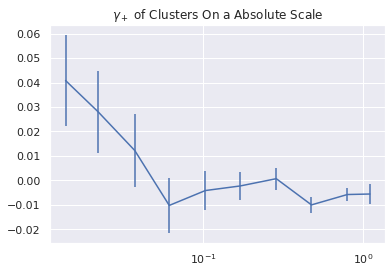

Aggregated xi:
[ -3.6338  -8.5769  -6.0367   9.888    7.8873   8.8275  -5.2435 127.9138
 135.2439  56.7027]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -380.5985 -1165.3706 -1621.5145 -2698.2133 -4326.4624 -6903.4246
 -9209.0992 -9537.9039 -5411.297    951.7996]
------------------------------------------------------------------------------
Aggregated npairs:
[   89.   306.   494.   968.  1906.  3901.  7361. 12794. 23481. 10204.]
------------------------------------------------------------------------------
Mean xi:
[-0.0408 -0.028  -0.0122  0.0102  0.0041  0.0023 -0.0007  0.01    0.0058
  0.0056]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2764 -3.8084 -3.2824 -2.7874 -2.2699 -1.7697 -1.2511 -0.7455 -0.2305
  0.0933]
------------------------------------------------------------------------------


In [29]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

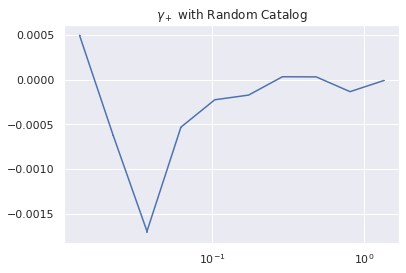

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [30]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

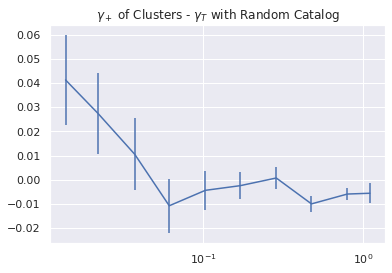

In [31]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

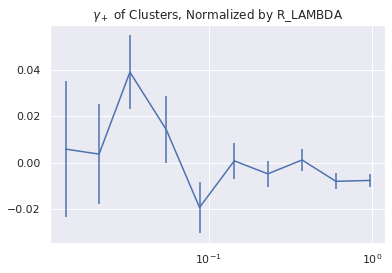

Aggregated xi:
[ -0.1758  -0.5667 -12.7497  -8.2547  19.6523  -1.6394  18.6162  -8.1833
  94.1803 156.7693]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -129.4749  -592.008  -1115.2249 -1684.3442 -2480.176  -4010.3278
 -5708.9799 -6963.9365 -6035.8693  -724.7066]
------------------------------------------------------------------------------
Aggregated npairs:
[   30.   154.   327.   581.  1020.  2064.  3879.  7042. 11751. 20525.]
------------------------------------------------------------------------------
Mean xi:
[-0.0059 -0.0037 -0.039  -0.0142  0.0193 -0.0008  0.0048 -0.0012  0.008
  0.0076]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3158 -3.8442 -3.4105 -2.899  -2.4315 -1.943  -1.4718 -0.9889 -0.5136
 -0.0353]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [32]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)